# Machine Learning Engineer Nanodegree
## Lin Muqing
## Capstone Data Exploration

In [1]:
# Import libraries necessary for this project
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gc
import seaborn as sns
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
if not os.path.exists('figs'):
    os.mkdir('figs')
import collections

# Pretty display for notebooks
%matplotlib inline

In [2]:
# Load raw dataset
sample_submission = pd.read_csv('data/sample_submission.csv', low_memory=False)
sub_index = sample_submission['ParcelId']
prop_2016 = pd.read_csv('data/properties_2016.csv', low_memory=False)
prop_2016.index = prop_2016['parcelid']
prop_2017 = pd.read_csv('data/properties_2017.csv', low_memory=False)
prop_2017.index = prop_2017['parcelid']

def size_control(data):
    data.loc[:, ['latitude', 'longitude']] = data.loc[:, ['latitude', 'longitude']] / 1e6
    # cannot do float32 transform, it loses info for census_tract and block info
#     for col in data.columns:
#         if data[col].dtype == np.float64:
#             data.loc[:, col] = data[col].astype(np.float32)

size_control(prop_2016)
size_control(prop_2017)

# make sure prediction index order is inline with expected submission index order
prop_2016 = prop_2016.loc[sub_index, :]
prop_2017 = prop_2017.loc[sub_index, :]
prop_data = pd.concat([prop_2016, prop_2017], axis=0)
prop_data.index = list(range(prop_data.shape[0]))

train_2016 = pd.read_csv('data/train_2016_v2.csv')
train_2017 = pd.read_csv('data/train_2017.csv')

train_2016 = pd.merge(train_2016, prop_2016, how='left', on='parcelid')
train_2017 = pd.merge(train_2017, prop_2017, how='left', on='parcelid')

train_data = pd.concat([train_2016, train_2017], axis=0)
train_data.index = list(range(train_data.shape[0]))
train_data['sale_month'] = train_data['transactiondate'].apply(lambda x: x.split('-')[1])  # get error data transaction date to month
train_data['abs_logerror'] = np.abs(train_data['logerror'])

In [3]:
# train_data = pd.read_csv('data/train_data_merged.csv', header=0)
prop_data_copy = prop_data.copy()
train_data_copy = train_data.copy()

In [4]:
# shape of data
n_total = prop_data.shape[0]
n_train = train_data.shape[0]
print('total_data shape: ' + str(prop_data.shape))
print('train_data shape: ' + str(train_data.shape))

total_data shape: (5970434, 58)
train_data shape: (167888, 62)


In [5]:
feature_cols = ['new_name', 'type', 'class', 'prop_missing', 'train_missing']
feature_info = {}

In [6]:
# util functions
def print_samples(col, n_sample=8, n_digit=None):
    vals = prop_2016.loc[prop_2016.index[~prop_2016[col].isnull()], col].values
    np.random.shuffle(vals)
    print('data type: ' +  str(prop_data[col].dtype))
    data_points = ''
    for i in range(n_sample):
        if str(prop_data[col].dtype) in {'float64', 'float32'} and n_digit.__class__ != None.__class__:
            data_points += format(vals[i], '.%df' % n_digit)
        else:
            data_points += str(vals[i])
        if i != n_sample - 1:
            data_points += ', '
    print('sample data points: ' + data_points)

        
def col_fill_na(data, col, fill):
    if fill == 'mode':
        data[col].fillna(data[col].mode().values[0], inplace=True)
    elif fill == 'mean':
        data[col].fillna(data[col].mean(), inplace=True)
    elif fill == '0':
        data[col].fillna(0, inplace=True)
    else:
        print('unknown fill type: %s' % fill)
        

def recover_col(col):
    prop_data[col] = prop_data_copy[col].copy()
    train_data[col] = train_data_copy[col].copy()


def save_feature_info_to_csv():
    feature_info_df = pd.DataFrame(feature_info)
    feature_info_df = feature_info_df.T
    feature_info_df.columns = feature_cols
    feature_info_df.to_csv('data/feature_info.csv', index_label='orig_name', float_format='%.4f')


def cat_num_to_str(col_name):
    """for numeric-like categorical varible, transform to string, keep nan"""
    if not prop_data[col_name].dtype == 'O':
        prop_data[col_name] = prop_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)
    if not train_data[col_name].dtype == 'O':
        train_data[col_name] = train_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)


def mark_flag_col(col_name):
    """mark bool for numerical columns, mark True for val > 0, and False otherwise (include NaN)"""
    prop_data_marks_true = prop_data[col_name] >= 0.5
    prop_data.loc[prop_data.index[prop_data_marks_true], col_name] = 'TRUE'
    prop_data.loc[prop_data.index[~prop_data_marks_true], col_name] = 'FALSE'
    train_data_marks_true = train_data[col_name] >= 0.5
    train_data.loc[train_data.index[train_data_marks_true], col_name] = 'TRUE'
    train_data.loc[train_data.index[~train_data_marks_true], col_name] = 'FALSE'

        
def cat_feature_analysis(col_name):
    """analysis of categorical feature, comparing number of unique appeared values between train_data and prop_data, with NaN removed.
       For those values appear in train but not in prop, need to properly handle for prop in prediction."""    
    prop_col_no_nan = prop_data[col_name][~prop_data[col_name].isnull()]
    train_col_no_nan = train_data[col_name][~train_data[col_name].isnull()]
    vals_prop = np.sort(prop_col_no_nan.unique())
    vals_train = np.sort(train_col_no_nan.unique())
    if len(vals_train) < 15:
        print('vals from train_data: %s' % ', '.join([str(v) for v in vals_train]))
    val_prop_de_train = set(vals_prop) - set(vals_train)
    print('n_vals from train_data: %d' % len(vals_train))
    if val_prop_de_train:
        if len(val_prop_de_train) < 15:
            print('vals in prop not in train: %s' % ', '.join([str(v) for v in sorted(list(val_prop_de_train))]))
        print('n_vals in prop not in train: %d' % len(val_prop_de_train))
        # summarize ratio of not appeared-in-training value samples in total porpulation
        n_sample = np.sum(np.array([i in val_prop_de_train for i in prop_data[col_name]]))
        print('ratio sample with val in prop not in train: %4.6f' % (n_sample / float(n_total)))
    else:
        print('prop and train vals set consistent')
    return val_prop_de_train 


def missing_ratio(col_name):
    """compare missing rate in prop data and train data. A good feature should have similar ratio in both training and total population."""
    prop_missing = np.sum(prop_data[col_name].isnull()) / float(n_total)
    train_missing = np.sum(train_data[col_name].isnull()) / float(n_train)
    print('missing ratio prop: %4.4f' % prop_missing)
    print('missing ratio train: %4.4f' % train_missing)
    return prop_missing, train_missing
    

def visual_analysis_num(col_name, col_name_disp):
    """view relationship to error for numerical variables, summarize for NaN separately"""
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    train_col_values = train_data[col_name].values
    sns.distplot(train_col_values[~np.isnan(train_col_values)], ax=ax1).set_title('density')  # 1, density plot
    fit_logerror = lowess(train_data['logerror'], train_data[col_name], return_sorted =False, it=0)
    sns.regplot(train_data[col_name], fit_logerror, fit_reg=False, ax=ax2).set_title('against logerror')  # 2, logerror
    fit_abs_logerror = lowess(train_data['abs_logerror'], train_data[col_name], return_sorted =False, it=0)
    sns.regplot(train_data[col_name], fit_abs_logerror, fit_reg=False, ax=ax3).set_title('against abs_logerror')  # 3, abs_logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()
    fig.savefig('figs/explore_%s.png' % col_name_disp)


def visual_analysis_cat(col_name, col_name_disp):
    """view relationship to error for categorical variables"""
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.countplot(train_data[col_name], ax=ax1).set_title('density')  # 1, density plot
    sns.barplot(x=col_name, y='logerror', data=train_data, ax=ax2).set_title('against logerror')  # 2, logerror
    sns.barplot(x=col_name, y='abs_logerror', data=train_data, ax=ax3).set_title('against abs logerror')  # 3, logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()
    fig.savefig('figs/explore_%s.png' % col_name_disp)
    
    
def visual_analysis_num_as_cat(col_name, col_name_disp):
    """kde density and regression line could be misleading for small-finite-set int variable, plot is as categorical"""
    cal_name_as_cat = col_name + 'as_cat'
    train_data[cal_name_as_cat] = train_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)
    groups = np.array(train_data[cal_name_as_cat].unique())
    order = np.array([float(i) for i in groups]).argsort()
    ordered_groups = groups[order]
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.countplot(train_data[cal_name_as_cat], order=ordered_groups, ax=ax1).set_title('density')  # 1, density plot
    sns.barplot(x=cal_name_as_cat, y='logerror', data=train_data, order=ordered_groups, ax=ax2).set_title('against logerror')  # 2, logerror
    sns.barplot(x=cal_name_as_cat, y='abs_logerror', data=train_data, order=ordered_groups, ax=ax3).set_title('against abs logerror')  # 3, logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()
    fig.savefig('figs/explore_%s_as_cat.png' % col_name_disp)

### airconditioningtypeid

Description: Type of cooling system present in the home (if any). And further description gives

| Type ID  | Description  |
|----------|---|
|1	     |Central|
|2	     |Chilled Water|
|3	     |Evaporative Cooler|
|4	     |Geo Thermal|
|5	     |None|
|6	     |Other|
|7	     |Packaged AC Unit|
|8	     |Partial|
|9	     |Refrigeration|
|10	     |Ventilation|
|11	     |Wall Unit|
|12	     |Window Unit|
|13	     |Yes|

From where we can see it is a categorical variable. And None is already included in description, so NaN is trully missing.


data type: float64
sample data points: 1.0, 13.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
vals from train_data: 1, 11, 13, 3, 5, 9
n_vals from train_data: 6
vals in prop not in train: 12
n_vals in prop not in train: 1
ratio sample with val in prop not in train: 0.000020
missing ratio prop: 0.7275
missing ratio train: 0.6796


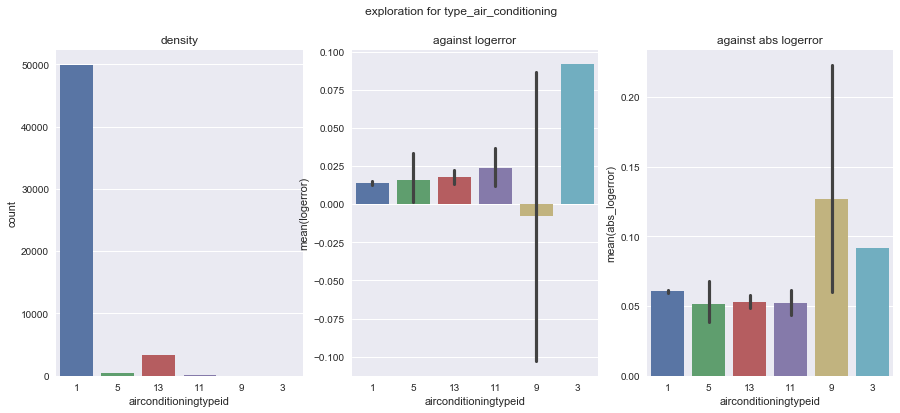

In [7]:
print_samples('airconditioningtypeid')
cat_num_to_str('airconditioningtypeid')
cat_feature_analysis('airconditioningtypeid')
prop_missing, train_missing = missing_ratio('airconditioningtypeid')
visual_analysis_cat('airconditioningtypeid', 'type_air_conditioning')

In [8]:
# Relatively high missing rate, imbalanced group distribution, and not much difference between two groups.
feature_info['airconditioningtypeid'] = ['type_air_conditioning', 'cat', 2, prop_missing, train_missing]

### architecturalstyletypeid

Description:  Architectural style of the home (i.e. ranch, colonial, split-level, etc…). And further description gives

| Type ID  | Description  |
|----------|---|
|1	| A-Frame |
|2	| Bungalow |
|3	| Cape Cod |
|4	| Cottage |
|5	| Colonial |
|6	| Custom |
|7	| Contemporary |
|8	| Conventional |
|9	| Dome |
|10	| French Provincial |
|11	| Georgian |
|12	| High Rise |
|13	| Historical |
|14	| Log Cabin/Rustic |
|15	| Mediterranean |
|16	| Modern |
|17	| Mansion |
|18	| English |
|19	| Other |
|20	| Prefab |
|21	| Ranch/Rambler |
|22	| Raised Ranch |
|23	| Spanish |
|24	| Traditional |
|25	| Tudor |
|26	| Unfinished/Under Construction |
|27	| Victorian |

It is also a categorical variable. And since is a style, so NaN is trully missing.

data type: float64
sample data points: 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0
vals from train_data: 10, 2, 21, 3, 7, 8
n_vals from train_data: 6
vals in prop not in train: 27, 5
n_vals in prop not in train: 2
ratio sample with val in prop not in train: 0.000007
missing ratio prop: 0.9980
missing ratio train: 0.9972


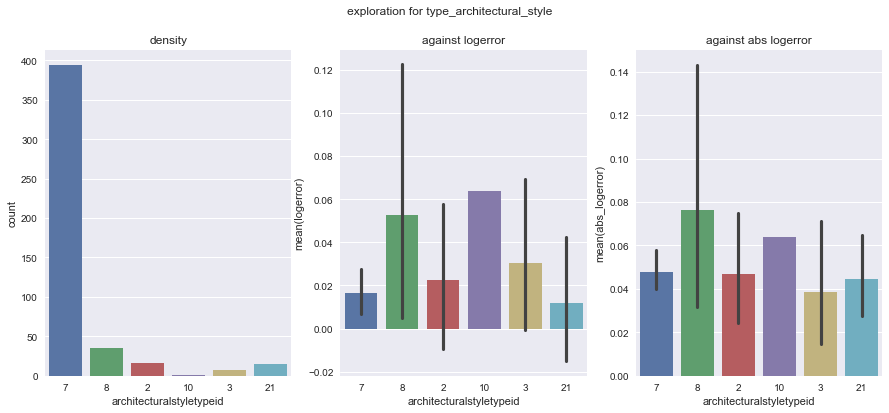

In [9]:
print_samples('architecturalstyletypeid')
cat_num_to_str('architecturalstyletypeid')
cat_feature_analysis('architecturalstyletypeid')
prop_missing, train_missing = missing_ratio('architecturalstyletypeid')
visual_analysis_cat('architecturalstyletypeid', 'type_architectural_style')

In [10]:
# missing rate too high
feature_info['architecturalstyletypeid'] = ['type_architectural_style', 'cat', 4, prop_missing, train_missing]

### basementsqft

Description:  Finished living area below or partially below ground level. So it is a numerical value

data type: float64
sample data points: 144.0, 377.0, 549.0, 519.0, 351.0, 506.0, 308.0, 1230.0
missing ratio prop: 0.9995
missing ratio train: 0.9994


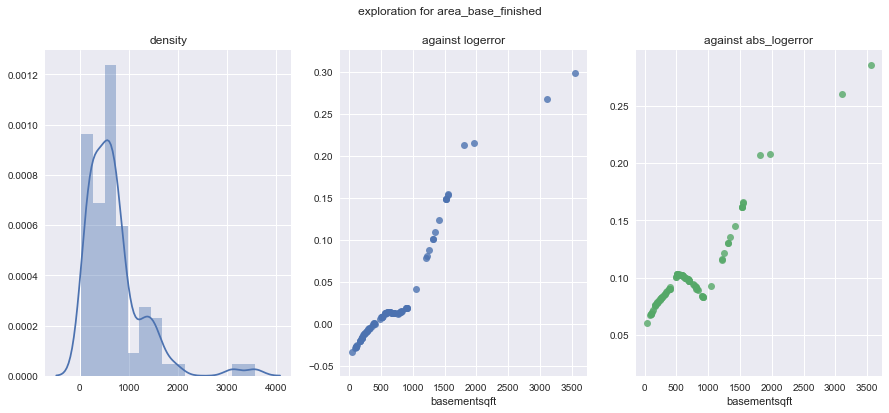

In [11]:
print_samples('basementsqft')
prop_missing, train_missing = missing_ratio('basementsqft')
visual_analysis_num('basementsqft', 'area_base_finished')

In [12]:
# missing rate is too high
feature_info['basementsqft'] = ['area_base_finished', 'num', 4, prop_missing, train_missing]

### bathroomcnt

Description: Number of bathrooms in home including fractional bathrooms. Also, according to FAQ, for some features there two versions, one from assessor and one from Zillow internally. This one is from assessor. For following feature exporation, those with post fix '_zillow' and 'assessor' are of this type.

data type: float64
sample data points: 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.5
missing ratio prop: 0.0024
missing ratio train: 0.0002


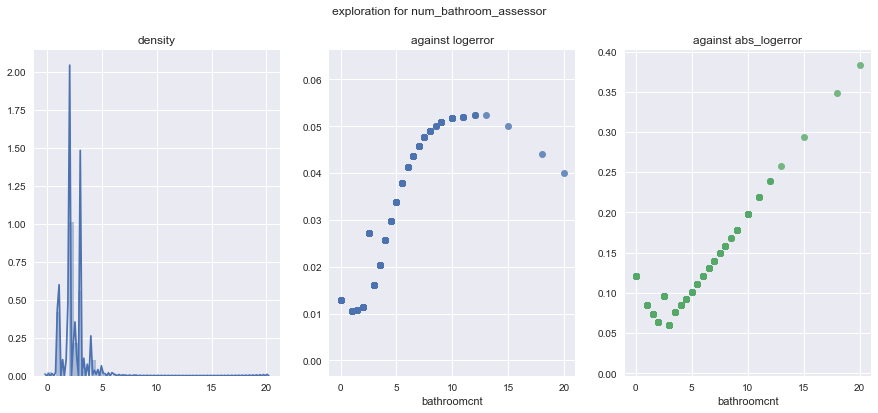

In [13]:
print_samples('bathroomcnt')
prop_missing, train_missing = missing_ratio('bathroomcnt')
visual_analysis_num('bathroomcnt', 'num_bathroom_assessor')  # we have fractions here, cannot use num_as_cat

In [14]:
# low missing rate, pattern in high density area
feature_info['bathroomcnt'] = ['num_bathroom_assessor', 'num', 1, prop_missing, train_missing]

### calculatedbathnbr

Description: Number of bathrooms in home including fractional bathroom.

data type: float64
sample data points: 2.0, 2.0, 2.0, 1.0, 1.0, 2.5, 3.0, 2.0
missing ratio prop: 0.0412
missing ratio train: 0.0109


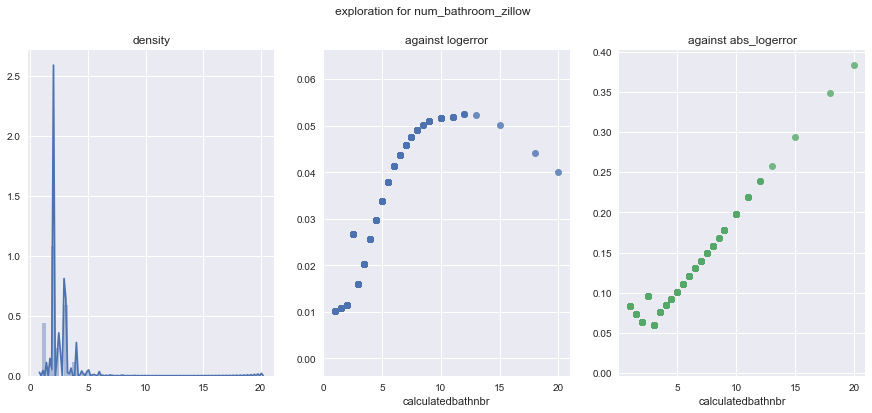

In [15]:
print_samples('calculatedbathnbr')
prop_missing, train_missing = missing_ratio('calculatedbathnbr')
visual_analysis_num('calculatedbathnbr', 'num_bathroom_zillow')

In [16]:
# low missing rate, weak pattern in high density area, keep for now
feature_info['calculatedbathnbr'] = ['num_bathroom_zillow', 'num', 1, prop_missing, train_missing]

### bedroomcnt

Description:  Number of bedrooms in home.

data type: float64
sample data points: 2.0, 3.0, 3.0, 4.0, 6.0, 3.0, 2.0, 3.0
missing ratio prop: 0.0024
missing ratio train: 0.0002


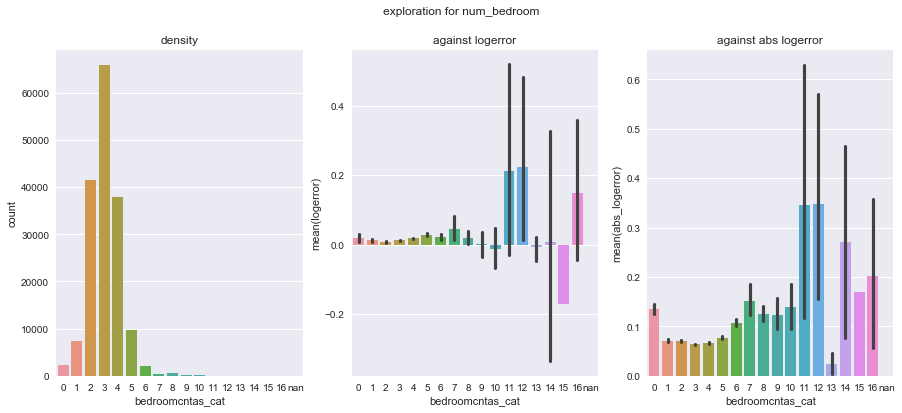

In [17]:
print_samples('bedroomcnt')
prop_missing, train_missing = missing_ratio('bedroomcnt')
visual_analysis_num_as_cat('bedroomcnt', 'num_bedroom')

In [18]:
# low missing rate, pattern in high density area
feature_info['bedroomcnt'] = ['num_bedroom', 'num', 1, prop_missing, train_missing]

### buildingclasstypeid

Description: The building framing type (steel frame, wood frame, concrete/brick). Detailed description too long, put is as bullets.

- 1: Buildings having fireproofed structural steel frames carrying all wall, floor and roof loads. Wall, floor and roof structures are built of non-combustible materials.
- 2: Buildings having fireproofed reinforced concrete frames carrying all wall floor and roof loads which are all non-combustible.
- 3: Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.
- 4: Buildings having wood or wood and steel frames
- 5: Specialized buildings that do not fit in any of the above categories

Categorical, NaN should be real missing, rename to 'type_building_framing'

data type: float64
sample data points: 4.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0
vals from train_data: 3, 4
n_vals from train_data: 2
vals in prop not in train: 1, 2, 5
n_vals in prop not in train: 3
ratio sample with val in prop not in train: 0.000068
missing ratio prop: 0.9958
missing ratio train: 0.9998


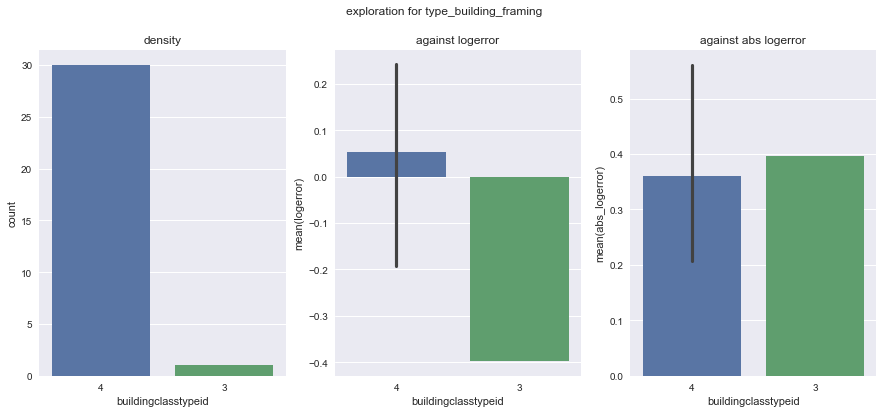

In [19]:
print_samples('buildingclasstypeid')
cat_num_to_str('buildingclasstypeid')
cat_feature_analysis('buildingclasstypeid')
prop_missing, train_missing = missing_ratio('buildingclasstypeid')
visual_analysis_cat('buildingclasstypeid', 'type_building_framing')

In [20]:
# too high missing rate drop
feature_info['buildingclasstypeid'] = ['type_building_framing', 'cat', 4, prop_missing, train_missing]

### buildingqualitytypeid

Overall assessment of condition of the building from best (lowest) to worst (highest). Although there is a 'typeid' in the name, it is not really categorical, rank between the values has actual meaning, take it as numerical

data type: float64
sample data points: 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0
missing ratio prop: 0.3502
missing ratio train: 0.3616


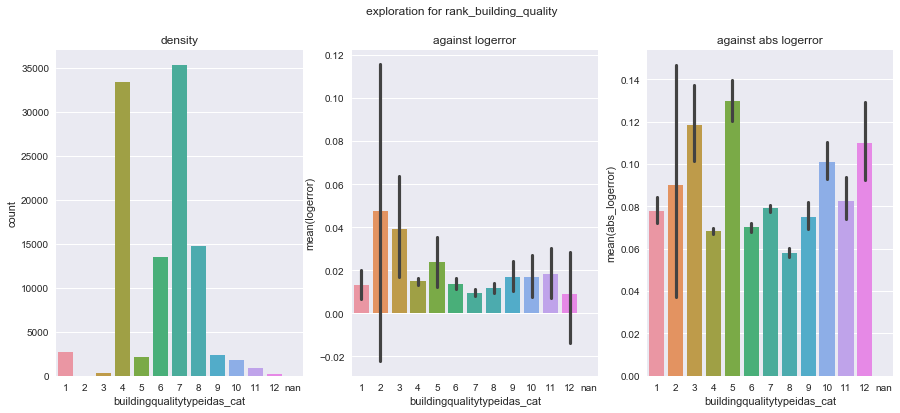

In [21]:
print_samples('buildingqualitytypeid')
prop_missing, train_missing = missing_ratio('buildingqualitytypeid')
visual_analysis_num_as_cat('buildingqualitytypeid', 'rank_building_quality')

In [22]:
# missing rate is not high, pattern in high density area
feature_info['buildingqualitytypeid'] = ['rank_building_quality', 'num', 1, prop_missing, train_missing]

### decktypeid

Description: Type of deck (if any) present on parcel.

data type: float64
sample data points: 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0
vals from train_data: 66
n_vals from train_data: 1
prop and train vals set consistent
missing ratio prop: 0.9942
missing ratio train: 0.9924


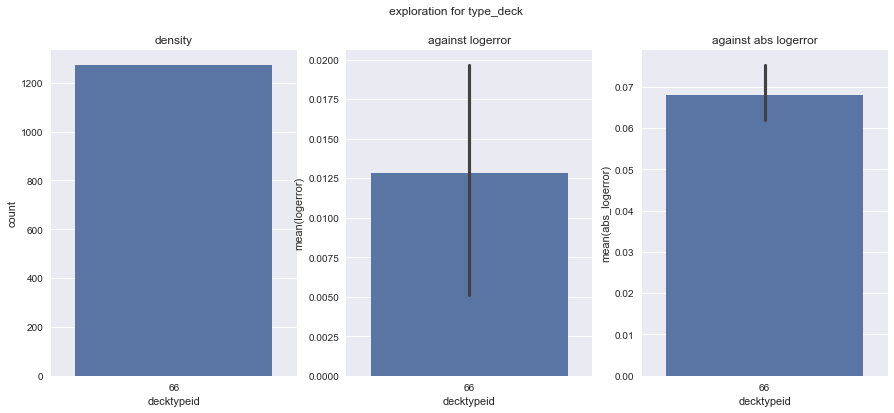

In [23]:
print_samples('decktypeid')
cat_num_to_str('decktypeid')
cat_feature_analysis('decktypeid')
prop_missing, train_missing = missing_ratio('decktypeid')
visual_analysis_cat('decktypeid', 'type_deck')

In [24]:
# missing rate too high, and only one value, drop it
feature_info['decktypeid'] = ['type_deck', 'cat', 4, prop_missing, train_missing]

### finishedfloor1squarefeet

Description: Size of the finished living area on the first (entry) floor of the home.

data type: float64
sample data points: 892.0, 1615.0, 738.0, 675.0, 1190.0, 816.0, 1170.0, 1440.0
missing ratio prop: 0.9319
missing ratio train: 0.9232


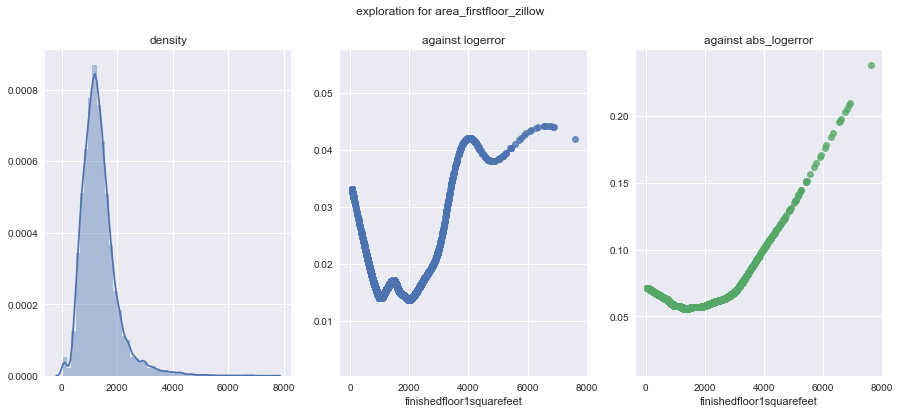

In [25]:
print_samples('finishedfloor1squarefeet')
prop_missing, train_missing = missing_ratio('finishedfloor1squarefeet')
visual_analysis_num('finishedfloor1squarefeet', 'area_firstfloor_zillow')

In [26]:
# missing rate too high drop the feature.
feature_info['finishedfloor1squarefeet'] = ['area_firstfloor_zillow', 'num', 4, prop_missing, train_missing]

### calculatedfinishedsquarefeet

Description: Calculated total finished living area of the home.

data type: float64
sample data points: 1472.0, 1517.0, 1487.0, 1919.0, 2751.0, 1360.0, 885.0, 2006.0
missing ratio prop: 0.0169
missing ratio train: 0.0053


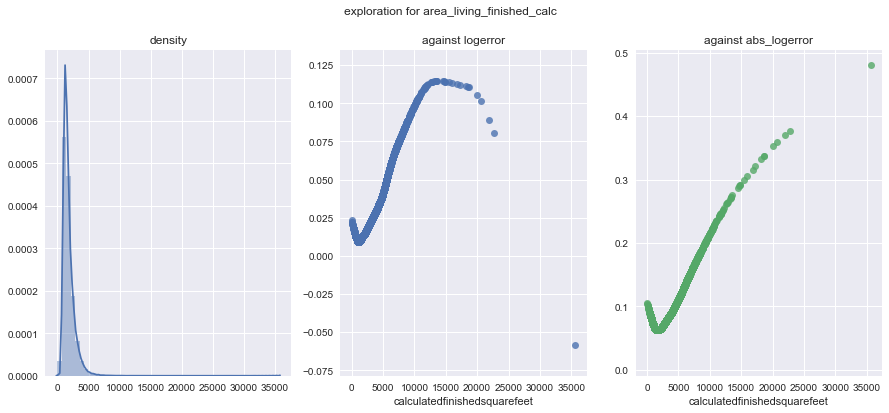

In [27]:
print_samples('calculatedfinishedsquarefeet')
prop_missing, train_missing = missing_ratio('calculatedfinishedsquarefeet')
visual_analysis_num('calculatedfinishedsquarefeet', 'area_living_finished_calc')

In [28]:
# low missing rate, obvious pattern in high density area
feature_info['calculatedfinishedsquarefeet'] = ['area_living_finished_calc', 'num', 1, prop_missing, train_missing]

### finishedsquarefeet12

Description: Finished living area. A specific type of measuring of living area.

data type: float64
sample data points: 1830.0, 1594.0, 3801.0, 1747.0, 1890.0, 780.0, 1414.0, 1910.0
missing ratio prop: 0.0905
missing ratio train: 0.0498


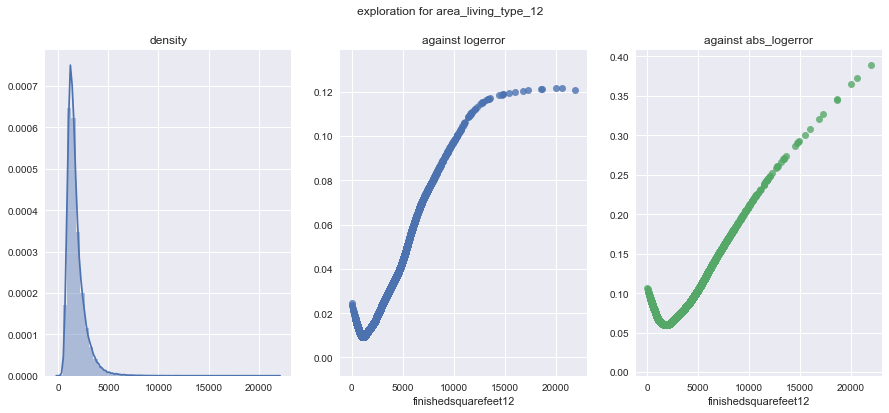

In [29]:
print_samples('finishedsquarefeet12')
prop_missing, train_missing = missing_ratio('finishedsquarefeet12')
visual_analysis_num('finishedsquarefeet12', 'area_living_type_12')

In [30]:
# missing ratio is very low, pattern similar to area_living_finished_calc
feature_info['finishedsquarefeet12'] = ['area_living_type_12', 'num', 1, prop_missing, train_missing]

### finishedsquarefeet13

Description: Perimeter living area. A specific type of measuring of living area.

data type: float64
sample data points: 1152.0, 960.0, 2040.0, 1440.0, 1344.0, 1200.0, 1368.0, 1536.0
missing ratio prop: 0.9974
missing ratio train: 0.9996


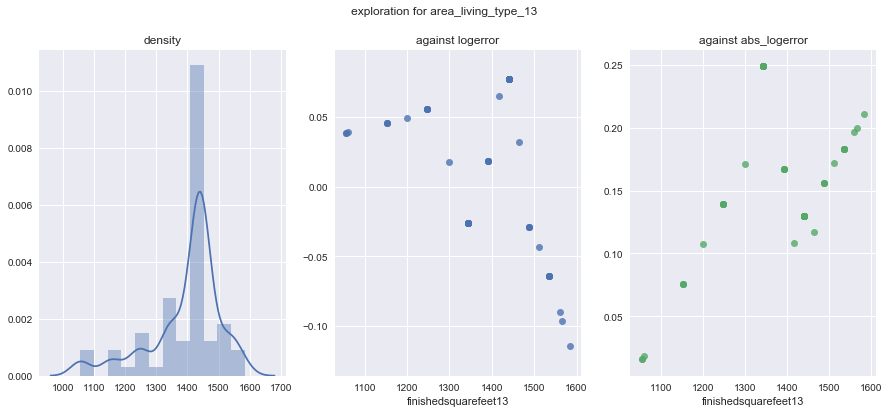

In [31]:
print_samples('finishedsquarefeet13')
prop_missing, train_missing = missing_ratio('finishedsquarefeet13')
visual_analysis_num('finishedsquarefeet13', 'area_living_type_13')

In [32]:
# high missing rate.
feature_info['finishedsquarefeet13'] = ['area_living_type_13', 'num', 4, prop_missing, train_missing]

### finishedsquarefeet15

Description: Total area. A specific type of measuring of living area.

data type: float64
sample data points: 1696.0, 3808.0, 4718.0, 2332.0, 3322.0, 1952.0, 3395.0, 3506.0
missing ratio prop: 0.9362
missing ratio train: 0.9607


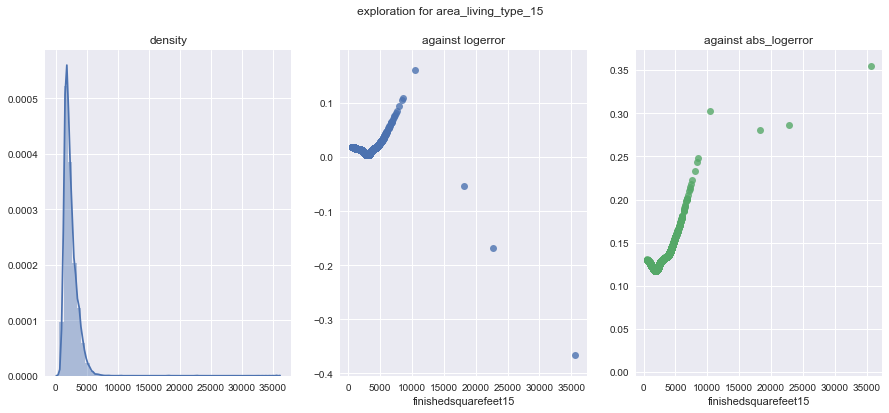

In [33]:
print_samples('finishedsquarefeet15')
prop_missing, train_missing = missing_ratio('finishedsquarefeet15')
visual_analysis_num('finishedsquarefeet15', 'area_living_type_15')

In [34]:
# high missing rate.
feature_info['finishedsquarefeet15'] = ['area_living_type_15', 'num', 4, prop_missing, train_missing]

### finishedsquarefeet50

Description: Size of the finished living area on the first (entry) floor of the home. Another first floor living area.

data type: float64
sample data points: 616.0, 1534.0, 1720.0, 1199.0, 1176.0, 883.0, 1787.0, 1624.0
missing ratio prop: 0.9319
missing ratio train: 0.9232


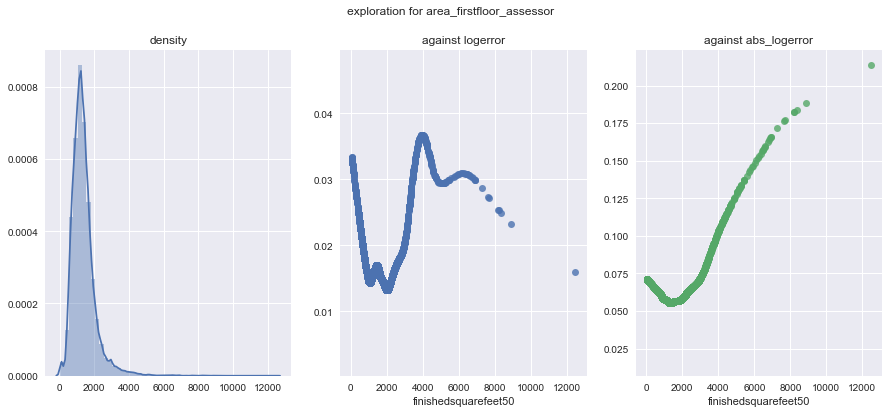

In [35]:
print_samples('finishedsquarefeet50')
prop_missing, train_missing = missing_ratio('finishedsquarefeet50')
visual_analysis_num('finishedsquarefeet50', 'area_firstfloor_assessor')

In [36]:
# high missing rate.
feature_info['finishedsquarefeet50'] = ['area_firstfloor_assessor', 'num', 4, prop_missing, train_missing]

### finishedsquarefeet6

Description: Base unfinished and finished area. Specific type of living area.

data type: float64
sample data points: 2976.0, 3433.0, 4635.0, 1878.0, 2925.0, 734.0, 2436.0, 1357.0
missing ratio prop: 0.9927
missing ratio train: 0.9952


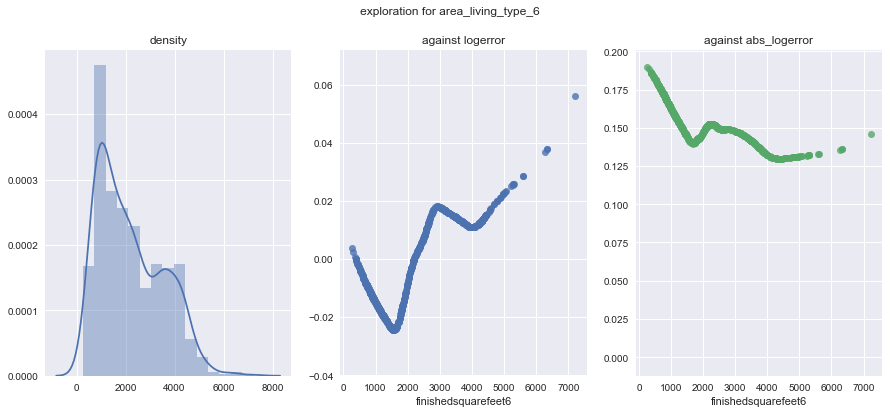

In [37]:
print_samples('finishedsquarefeet6')
prop_missing, train_missing = missing_ratio('finishedsquarefeet6')
visual_analysis_num('finishedsquarefeet6', 'area_living_type_6')

In [38]:
# high missing rate.
feature_info['finishedsquarefeet6'] = ['area_living_type_6', 'num', 4, prop_missing, train_missing]

### fips

Description: eral Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details. It is categorical treated as numerical numbers.

data type: float64
sample data points: 6037.0, 6037.0, 6037.0, 6059.0, 6059.0, 6037.0, 6037.0, 6037.0
vals from train_data: 6037, 6059, 6111
n_vals from train_data: 3
prop and train vals set consistent
missing ratio prop: 0.0024
missing ratio train: 0.0002


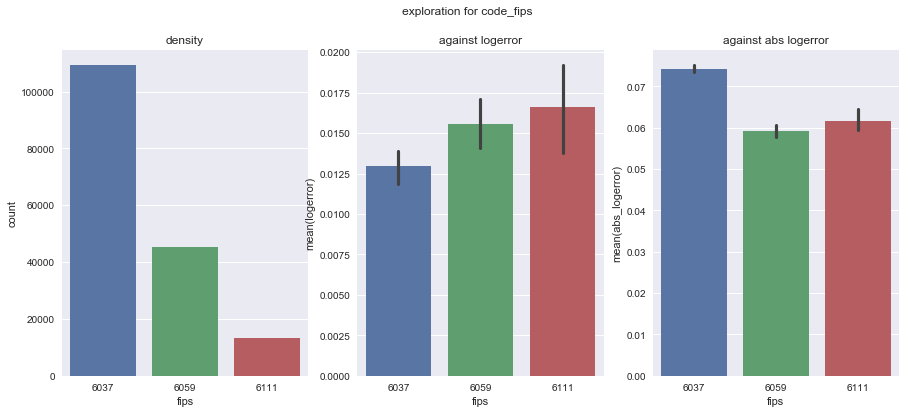

In [39]:
print_samples('fips')
cat_num_to_str('fips')
cat_feature_analysis('fips')
prop_missing, train_missing = missing_ratio('fips')
visual_analysis_cat('fips', 'code_fips')

In [40]:
# low missing rate, apparent patterns
feature_info['fips'] = ['code_fips', 'cat', 1, prop_missing, train_missing]

### fireplacecnt

Description: Number of fireplaces in a home (if any). '(if any)' means NaN could be handled as 0.

data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0
missing ratio prop: 0.8952
missing ratio train: 0.8934


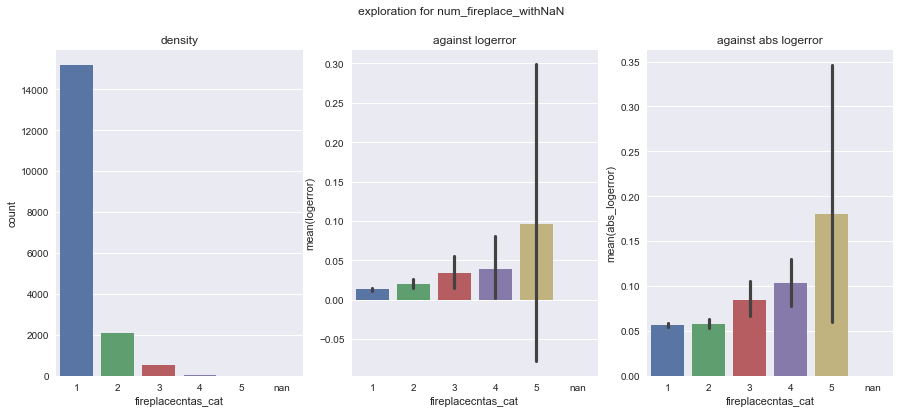

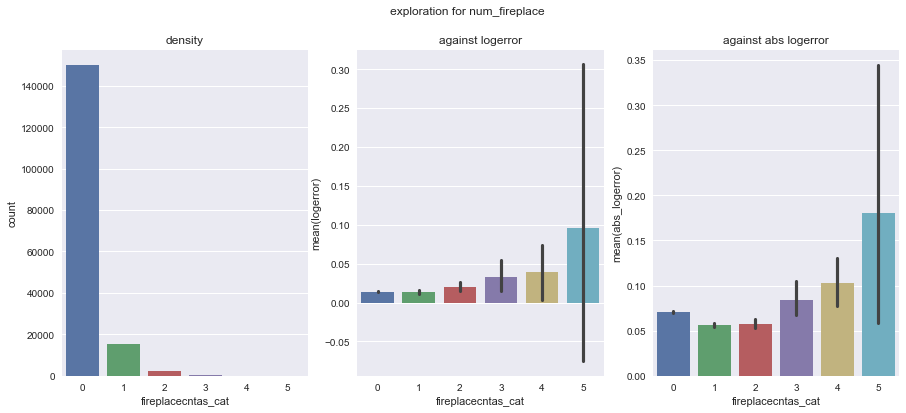

In [41]:
recover_col('fireplacecnt')
print_samples('fireplacecnt')
# checking missing ratio before impute
prop_missing, train_missing = missing_ratio('fireplacecnt')
visual_analysis_num_as_cat('fireplacecnt', 'num_fireplace_withNaN')
# impute NaN as 0 
prop_data['fireplacecnt'].fillna(0, inplace=True)
train_data['fireplacecnt'].fillna(0, inplace=True)
# no need to view missing ratio, directly add to feature
visual_analysis_num_as_cat('fireplacecnt', 'num_fireplace')

In [42]:
# missing rate is high, but there is pattern at non missing area.
# use this variable as imputing nan with 0, in that case the distribution is highly imbalanced, pattern is ignorable.
feature_info['fireplacecnt'] = ['num_fireplace', 'num', 2, 0.0, 0.0]

### fullbathcnt

Description: Number of full bathrooms (sink, shower + bathtub, and toilet) present in home. Meanwhile, we have 'bath room count' feature, which had no missing value. Below analysis shows that NaN full bathroom are not all having 0 bathroom, potentially we can impute it this way: 1, n_bathroom is fraction, take floor; 2, n_bathroom is int, reduce by 1. From analysis, this type of nan only takes less than 0.5% of all data, meanwhile max n_bathroom is 32, taking n_full_bath as 1 off seems not ideal, let's give up imputing for it. And rename to 'num_fullbath'.

data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 2.0
min num_full_bath in prop: 1
range of num_bath for NaN fullbath: min = 0, max = 8, nan_ratio = 0.0024
missing ratio prop: 0.0412
missing ratio train: 0.0109


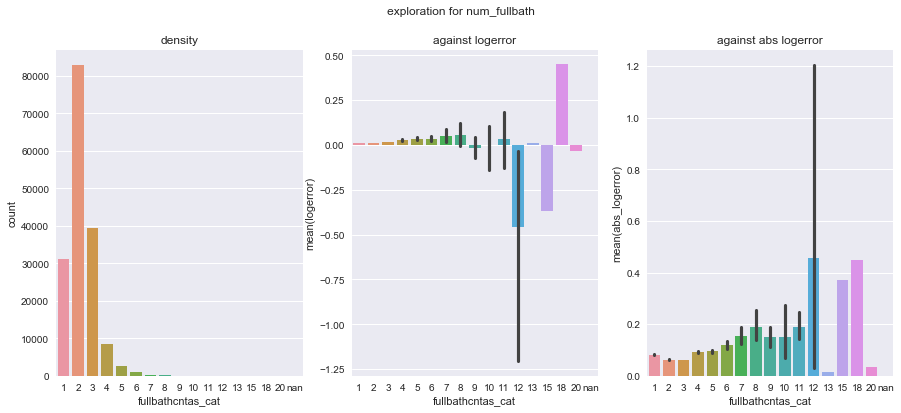

In [43]:
import math
recover_col('fullbathcnt')
print_samples('fullbathcnt')
print('min num_full_bath in prop: %d' % np.min(prop_data['fullbathcnt'].dropna()))
bathroomcnt_subset = prop_data['bathroomcnt'].loc[prop_data.index.values[prop_data['fullbathcnt'].isnull()]]
bathroomcnt_subset_n_nan = np.sum(bathroomcnt_subset.isnull())
bathroomcnt_subset_nonan = bathroomcnt_subset.dropna()
bathroomcnt_subset_nonan_max = bathroomcnt_subset_nonan.max()
bathroomcnt_subset_nonan_min = bathroomcnt_subset_nonan.min()
print('range of num_bath for NaN fullbath: min = %d, max = %d, nan_ratio = %4.4f' % (bathroomcnt_subset_nonan_min, bathroomcnt_subset_nonan_max, bathroomcnt_subset_n_nan / float(prop_data.shape[0])))

prop_missing, train_missing = missing_ratio('fullbathcnt')
col_fill_na(prop_data, 'bathroomcnt', 'mode')
visual_analysis_num_as_cat('fullbathcnt', 'num_fullbath')

In [44]:
# low original missing rate, pattern around high density area
feature_info['fullbathcnt'] = ['num_fullbath', 'num', 1, prop_missing, train_missing]

### garagecarcnt

Description:  Total number of garages on the lot including an attached garage. Have 0 in data, leave NaN as it is

data type: float64
sample data points: 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0
missing ratio prop: 0.7028
missing ratio train: 0.6697


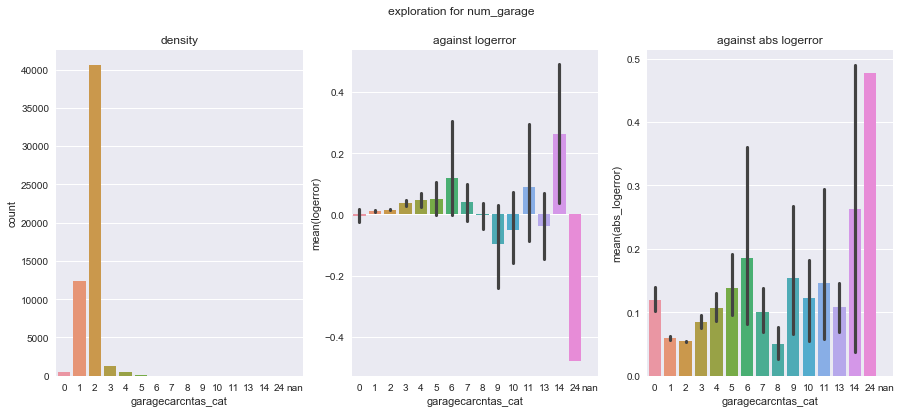

In [45]:
print_samples('garagecarcnt')
prop_missing, train_missing = missing_ratio('garagecarcnt')
visual_analysis_num_as_cat('garagecarcnt', 'num_garage')

In [46]:
# missing rate not low, also, no pattern in high density area
feature_info['garagecarcnt'] = ['num_garage', 'num', 2, prop_missing, train_missing]

### garagetotalsqft

Description: Total number of square feet of all garages on lot including an attached garage. It is found that besides NaN, there exists rows with zero garage area with non-zero garage count. It is more than 5% in total population, an intuitive fix is to fill these 0 area as median of garage area of those samples with the same garage count.

data type: float64
sample data points: 441.0, 440.0, 441.0, 460.0, 460.0, 462.0, 462.0, 433.0
invalid points ratio = 0.0619
missing ratio prop: 0.7028
missing ratio train: 0.6697


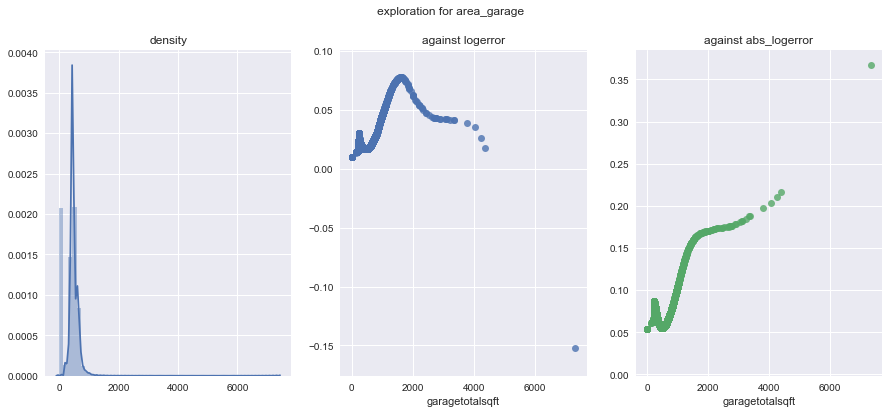

In [47]:
print_samples('garagetotalsqft')
n_invalid_points = np.sum(np.logical_and(np.abs(prop_data['garagetotalsqft'] - 0) < 1e-12, prop_data['garagecarcnt'] > 0))
print('invalid points ratio = %4.4f' % (n_invalid_points / float(prop_data.shape[0])))

prop_missing, train_missing = missing_ratio('garagetotalsqft')
visual_analysis_num('garagetotalsqft', 'area_garage')

In [48]:
# missing ratio looks high. but there looks pattern in high density area
feature_info['garagetotalsqft'] = ['area_garage', 'num', 2, prop_missing, train_missing]

### hashottuborspa

Description:  Does the home have a hot tub or spa. This is a bool, and value only has TRUE and NaN, so seems reasonable to put NaN as False and use this feature as category.

data type: object
sample data points: True, True, True, True, True, True, True, True
n TRUE samples: 3904


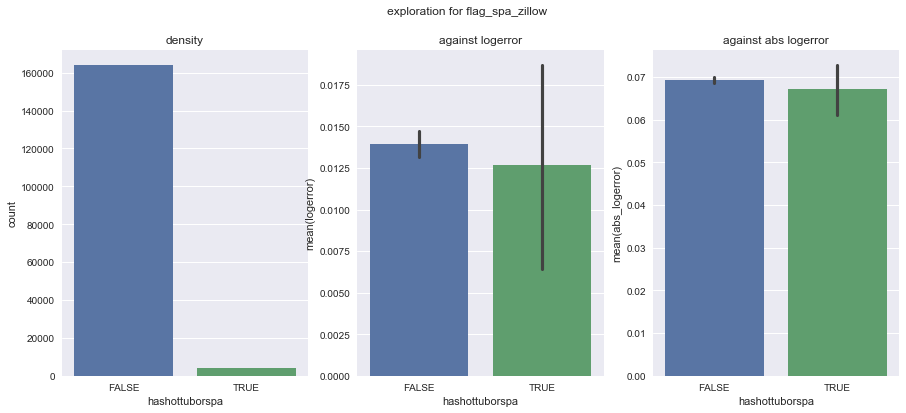

In [49]:
recover_col('hashottuborspa')
print_samples('hashottuborspa')  
mark_flag_col('hashottuborspa') # object 'True' is interpreted as bool in DataFrame, so can directly apply mark_flag_col
# no missing rate
visual_analysis_cat('hashottuborspa', 'flag_spa_zillow')
print('n TRUE samples: %d' % np.sum(train_data['hashottuborspa'] == 'TRUE'))

In [50]:
# quite imbalanced ditribution, num_true too small to make a valid split
feature_info['hashottuborspa'] = ['flag_spa_zillow', 'cat', 4, 0.0, 0.0]

### heatingorsystemtypeid

Description: Type of home heating system. Details of each type:

| Type ID  | Description  |
|----------|---|
|1	|Baseboard|
|2	|Central|
|3	|Coal|
|4	|Convection|
|5	|Electric|
|6	|Forced air|
|7	|Floor/Wall|
|8	|Gas|
|9	|Geo Thermal|
|10	|Gravity|
|11	|Heat Pump|
|12	|Hot Water|
|13	|None|
|14	|Other|
|15	|Oil|
|16	|Partial|
|17	|Propane|
|18	|Radiant|
|19	|Steam|
|20	|Solar|
|21	|Space/Suspended|
|22	|Vent|
|23	|Wood Burning|
|24	|Yes|
|25	|Zone|

Since None is already in there, should take NaN as true missing. 

data type: float64
sample data points: 2.0, 2.0, 7.0, 7.0, 2.0, 7.0, 2.0, 7.0
vals from train_data: 1, 10, 11, 12, 13, 14, 18, 2, 20, 24, 6, 7
n_vals from train_data: 12
vals in prop not in train: 19, 21
n_vals in prop not in train: 2
ratio sample with val in prop not in train: 0.000001
missing ratio prop: 0.3844
missing ratio train: 0.3707


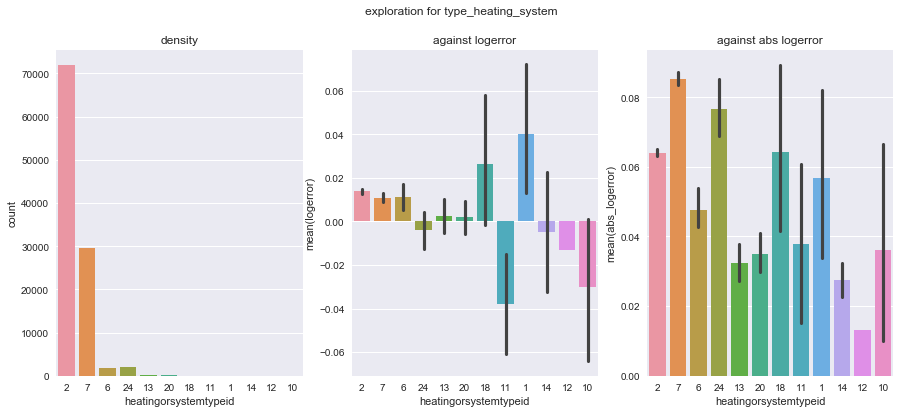

In [51]:
print_samples('heatingorsystemtypeid')
cat_num_to_str('heatingorsystemtypeid')
cat_feature_analysis('heatingorsystemtypeid')
prop_missing, train_missing = missing_ratio('heatingorsystemtypeid')
visual_analysis_cat('heatingorsystemtypeid', 'type_heating_system')

In [52]:
# missing rate is not too high, very good discrimination power.
feature_info['heatingorsystemtypeid'] = ['type_heating_system', 'cat', 1, prop_missing, train_missing]

### latitude

Description: Latitude of the middle of the parcel multiplied by 10e6. Typical numerical feature. Sure to include in model.

data type: float64
sample data points: 33.853921, 34.153855, 33.692418, 34.16419, 34.182122, 34.051757, 34.087243, 33.766311
missing ratio prop: 0.0024
missing ratio train: 0.0002


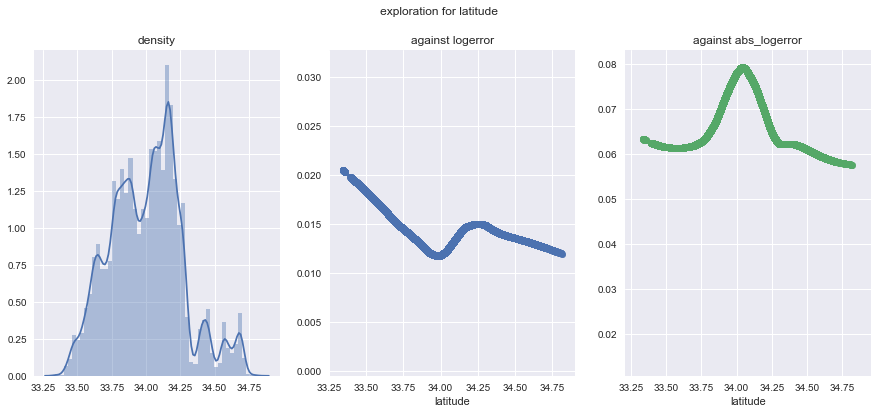

In [53]:
print_samples('latitude')
prop_missing, train_missing = missing_ratio('latitude')
visual_analysis_num('latitude', 'latitude')

In [54]:
# no missing, very good discrimination power.
feature_info['latitude'] = ['latitude', 'num', 1, prop_missing, train_missing]

### longitude

Description: Longitude of the middle of the parcel multiplied by 10e6. Typical numerical feature. Sure to include in model

data type: float64
sample data points: -118.454015, -118.991955, -118.3613, -118.386, -118.197432, -117.756109, -117.686838, -117.786515
missing ratio prop: 0.0024
missing ratio train: 0.0002


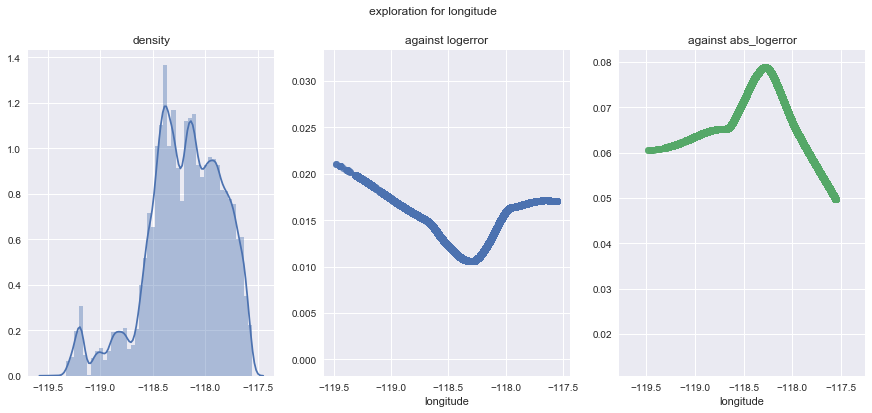

In [55]:
print_samples('longitude')
prop_missing, train_missing = missing_ratio('longitude')
visual_analysis_num('longitude', 'longitude')

In [56]:
# no missing, very good discrimination power.
feature_info['longitude'] = ['longitude', 'num', 1, prop_missing, train_missing]

### lotsizesquarefeet

Description: Area of the lot in square feet.

data type: float64
sample data points: 8632.0, 6250.0, 4408.0, 6251.0, 6993.0, 6440.0, 6496.0, 3871.0
missing ratio prop: 0.0919
missing ratio train: 0.1098


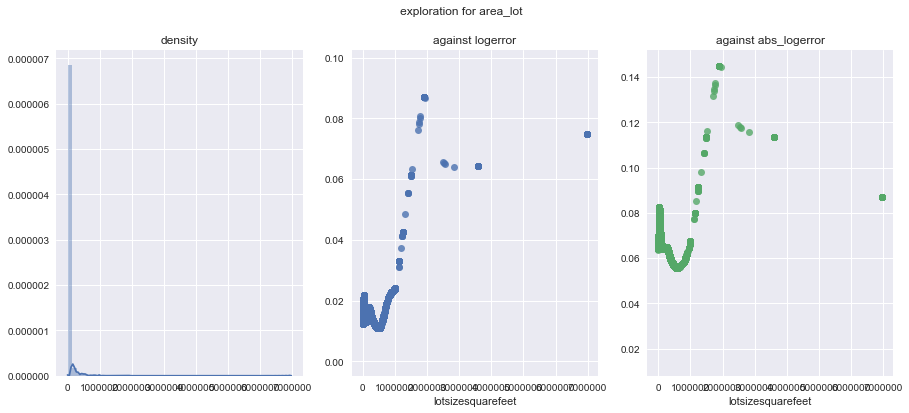

In [57]:
print_samples('lotsizesquarefeet')
prop_missing, train_missing = missing_ratio('lotsizesquarefeet')
visual_analysis_num('lotsizesquarefeet', 'area_lot')

In [58]:
# low missing rate, but density is too concentrated, looks pattern there, keep it as class 1
feature_info['lotsizesquarefeet'] = ['area_lot', 'num', 1, prop_missing, train_missing]

### poolcnt

Description: Number of pools on the lot (if any). From train data, the recorded values are either 1 or NaN. So make it a bool categorical variable, with >=1 -> TRUE and FALSE otherwise. Apply the same to prop data. rename it to 'flag_pool'.

data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


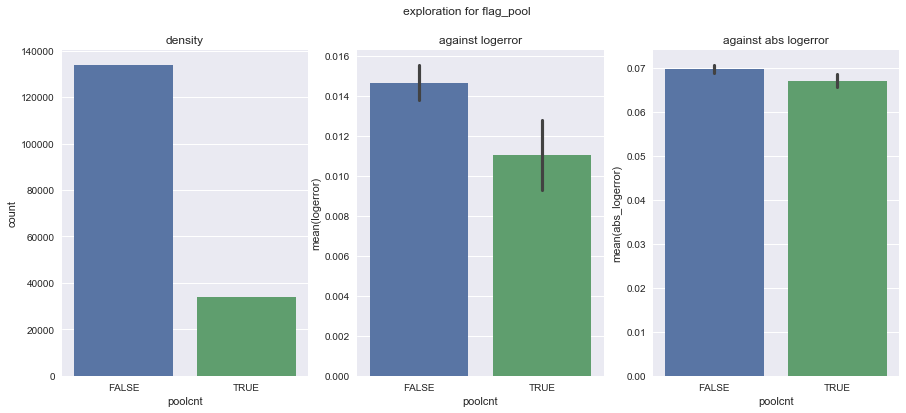

In [59]:
print_samples('poolcnt')
mark_flag_col('poolcnt')
visual_analysis_cat('poolcnt', 'flag_pool')

In [60]:
# very ideal discrimination power
feature_info['poolcnt'] = ['flag_pool', 'cat', 1, 0.0, 0.0]

### poolsizesum

Description: Total square footage of all pools on property. Numerical variable. Since we have marked number pool as existing or not, then flag_pool == FALSE set size to 0. leave others as nan or value given.

data type: float64
sample data points: 450.0, 642.0, 560.0, 594.0, 600.0, 648.0, 420.0, 400.0
missing ratio prop: 0.9906
missing ratio train: 0.9891
missing ratio after filling:
missing ratio prop: 0.1677
missing ratio train: 0.1920


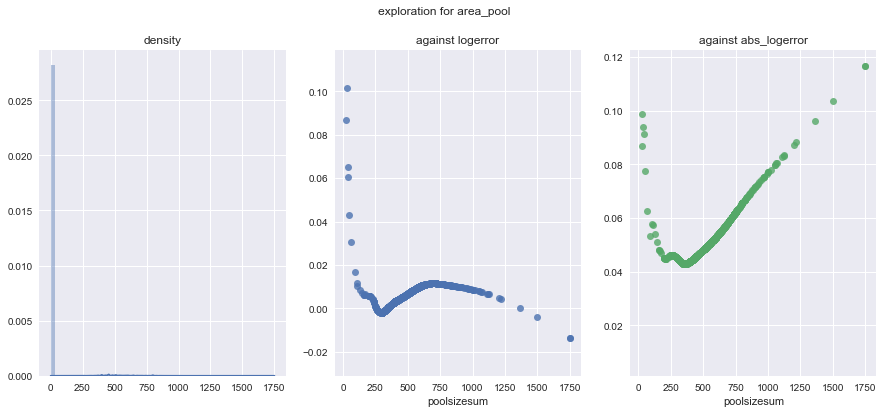

In [61]:
recover_col('poolsizesum')
print_samples('poolsizesum')
prop_missing, train_missing = missing_ratio('poolsizesum')
prop_data.loc[prop_data.index[prop_data['poolcnt'] == 'FALSE'], 'poolsizesum'] = 0.0
train_data.loc[train_data.index[train_data['poolcnt'] == 'FALSE'], 'poolsizesum'] = 0.0
print('missing ratio after filling:')
prop_missing, train_missing = missing_ratio('poolsizesum')
visual_analysis_num('poolsizesum', 'area_pool')

In [62]:
# original missing is very high, after filling from flag_pool, the missing rate is much lower. However, the KDE plot is somewhat misleading,
# it does not include the imputed zeros, so let's put it as a class 4 here.
feature_info['poolsizesum'] = ['area_pool', 'num', 4, prop_missing, train_missing]

### pooltypeid10

Description: Spa or Hot Tub. Seems to be a property of pool, but none of the has-value sample shows up with a TRUE pool count. Directly take a look at missing rate and patterns. It only has 1 or NaN, mark nan as FALSE. let's take a look at the pattern.

data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
n consistent pool_type_10 and pool cnt: 0
number TRUE: 1626


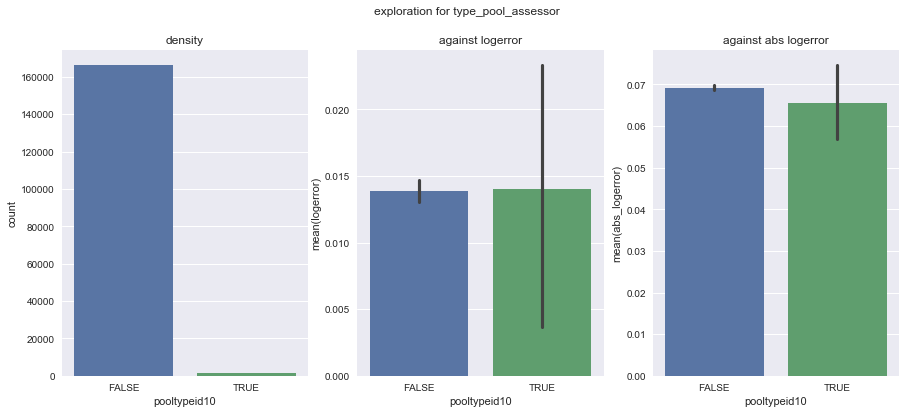

In [63]:
print_samples('pooltypeid10')
print('n consistent pool_type_10 and pool cnt: %d' % np.sum(np.logical_and(train_data['poolcnt'] == 'TRUE', train_data['pooltypeid10'] == 1)))
mark_flag_col('pooltypeid10')
visual_analysis_cat('pooltypeid10', 'type_pool_assessor')
print('number TRUE: %d' % (np.sum(train_data['pooltypeid10'] == 'TRUE')))

In [64]:
# It is not consistent with pool_flag, and considering the imbalanced distribution, I say not to use the variable at all.
feature_info['pooltypeid10'] = ['type_pool_assessor', 'cat', 4, 0.0, 0.0]

### pooltypeid2

Description: Pool with Spa/Hot Tub. So it describs details of pools. Together with next one:

### pooltypeid7

Description: Pool without hot tub.

Looks these two should be complementary and related to flag_pool.

In [65]:
recover_col('pooltypeid2')
recover_col('pooltypeid7')
print_samples('pooltypeid2')
print_samples('pooltypeid7')
# first mark names and transform features
mark_flag_col('pooltypeid2')
mark_flag_col('pooltypeid7')
# check flag_pool_type2 OR flag_pool_type7 == flag_pool, and flag_pool_type2 AND flag_pool_type7 == 0
flag_type2 = train_data['pooltypeid2'] == 'TRUE'
flag_type7 = train_data['pooltypeid7'] == 'TRUE'
flag_pool = train_data['poolcnt'] == 'TRUE'
print('num type2 OR type7 != pool: %d <expect 0>' % np.sum(np.logical_xor(np.logical_or(flag_type2, flag_type7), flag_pool)))
print('num type2 AND type7: %d <expect 0>' % np.sum(np.logical_and(flag_type2, flag_type7)))
print('number TRUE type2: %d' % (np.sum(train_data['pooltypeid2'] == 'TRUE'))) 
print('number TRUE type7: %d' % (np.sum(train_data['pooltypeid7'] == 'TRUE'))) 

data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
num type2 OR type7 != pool: 21 <expect 0>
num type2 AND type7: 0 <expect 0>
number TRUE type2: 2278
number TRUE type7: 31776


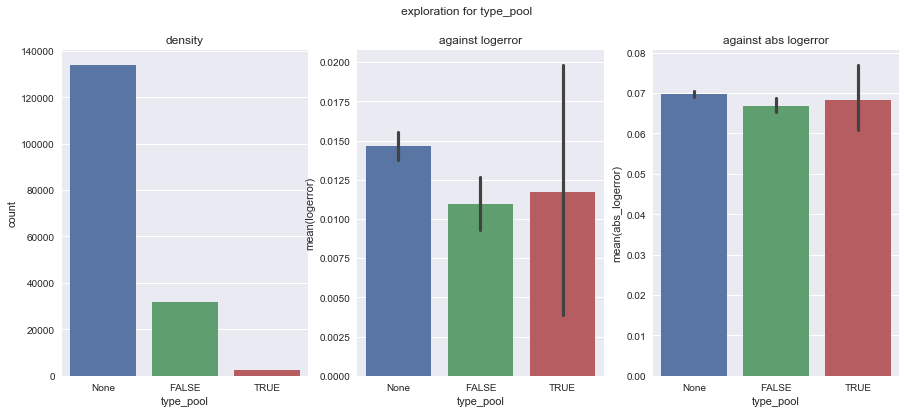

In [66]:
# It means we only need to keep one as feature, but need to make it as a new one, marking NaN as a new categroy.
def make_pool_type(data):
    data['type_pool'] = 'None'
    data.loc[data.index[data['pooltypeid2'] == 'TRUE'], 'type_pool'] = 'TRUE'
    data.loc[data.index[data['pooltypeid7'] == 'TRUE'], 'type_pool'] = 'FALSE'

# make grouped visualization of type_2, type_7. 
make_pool_type(prop_data)
make_pool_type(train_data)
visual_analysis_cat('type_pool', 'type_pool')

In [67]:
# size of type 7 is good enough, and sufficiently different from rest.
# although type_2 and type_7 are not consistent with flag_pool, since they are mutually exclusive, it is fine to group them as one feature.
feature_info['poolcnt'] = ['flag_pool', 'cat', 4, 0.0, 0.0]
feature_info['pooltypeid2'] = ['flag_pool_type_2', 'cat', 4, 0.0, 0.0]
feature_info['pooltypeid7'] = ['flag_pool_type_7', 'cat', 4, 0.0, 0.0]
feature_info['type_pool'] = ['type_pool', 'cat', 1, 0.0, 0.0]

### propertycountylandusecode

Description: County land use code i.e. it's zoning at the county level. It is categorical, but has frightening 78 categories.

In [68]:
print_samples('propertycountylandusecode')
print('n categories: %d' % len(train_data['propertycountylandusecode'].unique()))
prop_missing, train_missing = missing_ratio('propertycountylandusecode')

data type: object
sample data points: 0100, 010C, 1111, 1, 1111, 0100, 122, 122
n categories: 91
missing ratio prop: 0.0026
missing ratio train: 0.0002


In [69]:
# no missing, but number of category is too high, need to find a way to make it usable
feature_info['propertycountylandusecode'] = ['code_county_landuse', 'cat', 3, prop_missing, train_missing]

### propertylandusetypeid

Description: Type of land use the property is zoned for. Categorical again, but appeared as numerical.

data type: float64
sample data points: 261.0, 261.0, 261.0, 261.0, 266.0, 261.0, 246.0, 261.0
vals from train_data: 246, 247, 248, 260, 261, 263, 264, 265, 266, 267, 269, 275, 31, 47
n_vals from train_data: 14
vals in prop not in train: 270, 279
n_vals in prop not in train: 2
ratio sample with val in prop not in train: 0.000012
missing ratio prop: 0.0024
missing ratio train: 0.0002


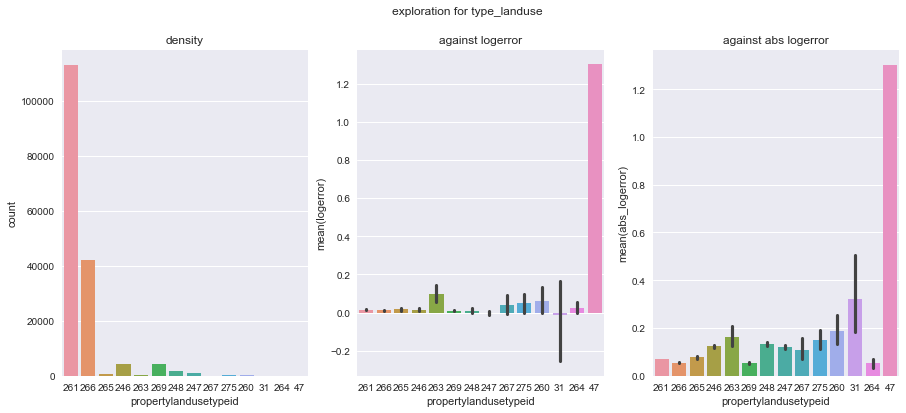

In [70]:
print_samples('propertylandusetypeid')
cat_num_to_str('propertylandusetypeid')
cat_feature_analysis('propertylandusetypeid')
prop_missing, train_missing = missing_ratio('propertylandusetypeid')
visual_analysis_cat('propertylandusetypeid', 'type_landuse')

In [71]:
# no missing, visible discrimination power on high density area, note the high variance
feature_info['propertylandusetypeid'] = ['type_landuse', 'cat', 1, prop_missing, train_missing]

### propertyzoningdesc

Description: Description of the allowed land uses (zoning) for that property. Categorical, with 1997 categories, let's skip it.

In [72]:
print_samples('propertyzoningdesc')
print('n categories: %d' % len(train_data['propertyzoningdesc'].unique()))
prop_missing, train_missing = missing_ratio('propertyzoningdesc')

data type: object
sample data points: LBR1N, INR2*, LCR1YY, LAR3, LAWC, RBR-1A, RMR2YY, LBR1N
n categories: 2347
missing ratio prop: 0.3365
missing ratio train: 0.3520


In [73]:
# too many categories, leave it for later
feature_info['propertyzoningdesc'] = ['str_zoning_desc', 'cat', 3, prop_missing, train_missing]

### rawcensustractandblock

Description: Census tract and block ID combined - also contains blockgroup assignment by extension. It is a combination of categorical information, but presented as float numerical, looks only 6 decimal digits are meaningful, the rest is precision noise:
1, first 4 digits is FIPS, just drop it.
2, next 6 digits, splitted by a dot, it census tract.
3, last 4 digits I assume it is block ID.
Let's create new features from it, as census_raw and block_raw.

In [74]:
print_samples('rawcensustractandblock', n_digit=10)
prop_missing, train_missing = missing_ratio('rawcensustractandblock')
print(train_data['rawcensustractandblock'].dtype)
def raw_census_info_split(data):
    data['temp'] = data['rawcensustractandblock'].apply(lambda x: str(int(round(x * 1000000))) if not np.isnan(x) else 'nan')
    data['temp'] = data['temp'].astype('O')
    data['raw_census'] = data['temp'].apply(lambda x: x[4:10] if not x == 'nan' else np.nan)
    data['raw_block'] = data['temp'].apply(lambda x: x[10:] if not x == 'nan' else np.nan)
    data.drop('temp', axis=1, inplace=True)
raw_census_info_split(prop_data)
raw_census_info_split(train_data)
print('n categories raw_census: %d' % len(train_data['raw_census'].unique()))
print('n categories raw block: %d' % len(train_data['raw_block'].unique()))

data type: float64
sample data points: 60372091.0220069960, 60374015.0020349994, 60590638.0210089982, 60374064.1220050082, 60590890.0420010015, 60375301.0109999999, 61110010.0110229999, 60372965.0010060072
missing ratio prop: 0.0024
missing ratio train: 0.0002
float64
n categories raw_census: 3020
n categories raw block: 785


In [75]:
# but need to impute for prop_data
feature_info['rawcensustractandblock'] = ['raw_census_block', 'none', 4, prop_missing, train_missing]
feature_info['raw_census'] = ['raw_census', 'cat', 3, prop_missing, train_missing]
feature_info['raw_block'] = ['raw_block', 'cat', 3, prop_missing, train_missing]

### regionidcity

Description: City in which the property is located (if any). The 'if any' here look strange, property has to lay in a city, so missing is NaN. It is a number like string, so should be transformed to categorical.

In [76]:
print_samples('regionidcity')
print('n categories regionidcity: %d' % len(train_data['regionidcity'].unique()))
prop_missing, train_missing = missing_ratio('regionidcity')

data type: float64
sample data points: 47762.0, 8384.0, 26531.0, 12447.0, 14542.0, 12447.0, 32380.0, 12447.0
n categories regionidcity: 179
missing ratio prop: 0.0209
missing ratio train: 0.0197


In [77]:
# number of categories is too high
feature_info['regionidcity'] = ['code_city', 'cat', 3, prop_missing, train_missing]

### regionidcounty

Description: County in which the property is located.

In [78]:
print_samples('regionidcounty')
print('n categories regionidcounty: %d' % len(train_data['regionidcounty'].unique()))
prop_missing, train_missing = missing_ratio('regionidcounty')
cat_num_to_str('fips')
cat_num_to_str('regionidcounty')
# look to be completely overlapping with fips
def map_fips(x):
    if x == '6037':
        return '3101'
    elif x == '6059':
        return '1286'
    else:
        return '2061'
prop_data['mapped_fips'] = prop_data['fips'].apply(map_fips)
print('n diff mapped fips vs. county code: %d' % np.sum(prop_data['mapped_fips'] != prop_data['regionidcounty']))

data type: float64
sample data points: 3101.0, 3101.0, 3101.0, 3101.0, 3101.0, 3101.0, 3101.0, 2061.0
n categories regionidcounty: 4
missing ratio prop: 0.0024
missing ratio train: 0.0002
n diff mapped fips vs. county code: 14369


In [79]:
# we already kept fips
feature_info['regionidcounty'] = ['code_county', 'cat', 4, prop_missing, train_missing]

### regionidneighborhood

Description: Neighborhood in which the property is located.

In [80]:
print_samples('regionidneighborhood')
print('n categories regionidneighborhood: %d' % len(train_data['regionidneighborhood'].unique()))
prop_missing, train_missing = missing_ratio('regionidneighborhood')

data type: float64
sample data points: 268581.0, 116430.0, 118887.0, 118208.0, 403197.0, 47950.0, 268473.0, 47880.0
n categories regionidneighborhood: 506
missing ratio prop: 0.6126
missing ratio train: 0.6010


In [81]:
feature_info['regionidneighborhood'] = ['code_neighborhood', 'cat', 3, prop_missing, train_missing]

### regionidzip

Description:  Zip code in which the property is located. code_zip

In [82]:
print_samples('regionidzip')
print('n categories regionidzip: %d' % len(train_data['regionidzip'].unique()))
prop_missing, train_missing = missing_ratio('regionidzip')

data type: float64
sample data points: 96185.0, 96193.0, 96244.0, 97064.0, 96364.0, 96346.0, 96385.0, 96379.0
n categories regionidzip: 391
missing ratio prop: 0.0045
missing ratio train: 0.0007


In [83]:
feature_info['regionidzip'] = ['code_zip', 'cat', 3, prop_missing, train_missing]

### roomcnt

Description: Total number of rooms in the principal residence

data type: float64
sample data points: 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
missing ratio prop: 0.0024
missing ratio train: 0.0002


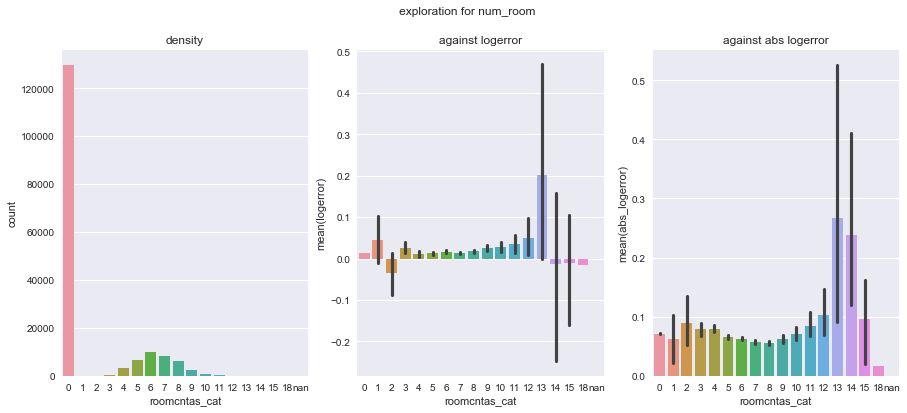

In [84]:
print_samples('roomcnt')
prop_missing, train_missing = missing_ratio('roomcnt')
visual_analysis_num_as_cat('roomcnt', 'num_room')

In [85]:
# high density area weak difference
feature_info['roomcnt'] = ['num_room', 'num', 2, prop_missing, train_missing]

### storytypeid

Description: Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.).  See tab for details. Details includes 35 types, I am not going to list all of them here.

data type: float64
sample data points: 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0
vals from train_data: 7
n_vals from train_data: 1
prop and train vals set consistent
missing ratio prop: 0.9995
missing ratio train: 0.9994


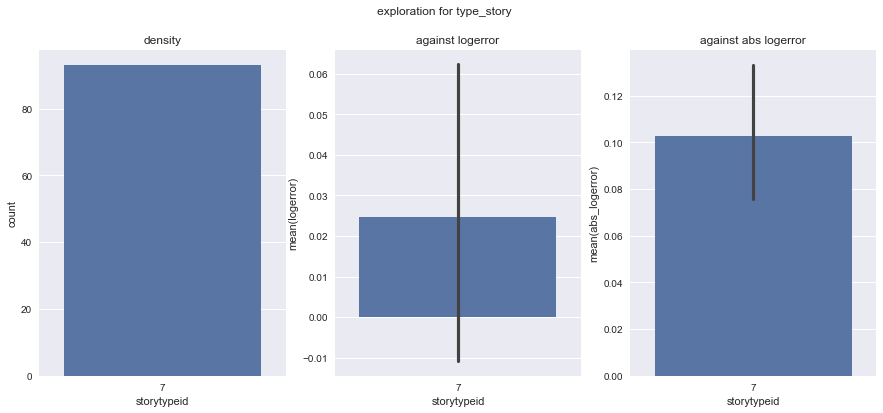

In [86]:
print_samples('storytypeid')
cat_num_to_str('storytypeid')
cat_feature_analysis('storytypeid')
prop_missing, train_missing = missing_ratio('storytypeid')
visual_analysis_cat('storytypeid', 'type_story')

In [87]:
# missing rate too high
feature_info['storytypeid'] = ['type_story', 'cat', 4, prop_missing, train_missing]

### threequarterbathnbr

Description: Number of 3/4 bathrooms in house (shower + sink + toilet). Min value is 1, use 0 for NaN.

data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
missing ratio prop: 0.8948
missing ratio train: 0.8683


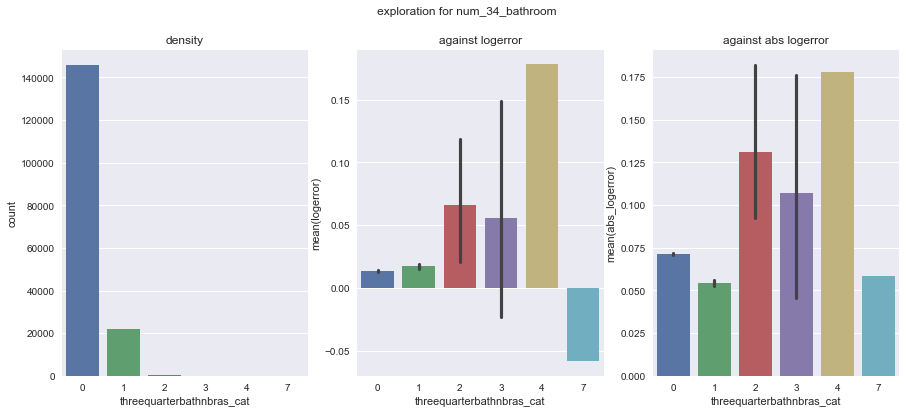

In [88]:
print_samples('threequarterbathnbr')
prop_missing, train_missing = missing_ratio('threequarterbathnbr')
col_fill_na(train_data, 'threequarterbathnbr', '0')
visual_analysis_num_as_cat('threequarterbathnbr', 'num_34_bathroom')

In [89]:
# high original missing rate, but when nan is interpreted as 0, we have noticable patterns 
feature_info['threequarterbathnbr'] = ['num_34_bathroom', 'num', 1, 0.0, 0.0]

### typeconstructiontypeid

Description: What type of construction material was used to construct the home. Categorical, 18 groups in total. It includes 'Other', so NaN can be treated as missing. I am not going to list all the detailed description here.

data type: float64
sample data points: 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0
vals from train_data: 10, 13, 4, 6
n_vals from train_data: 4
vals in prop not in train: 11
n_vals in prop not in train: 1
ratio sample with val in prop not in train: 0.000000
missing ratio prop: 0.9977
missing ratio train: 0.9969


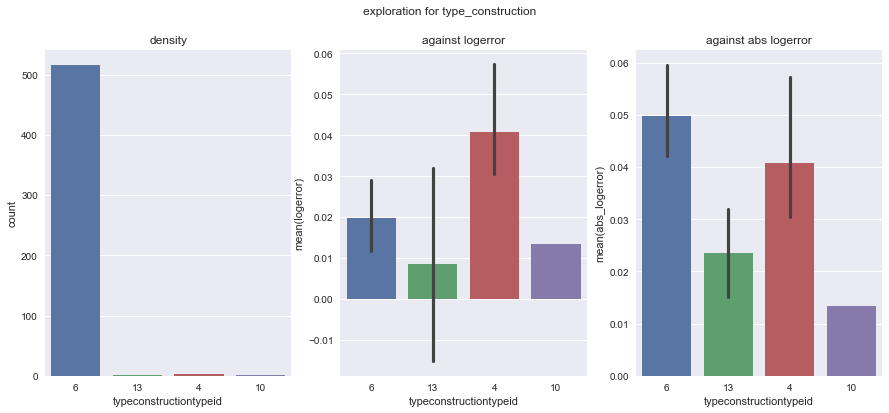

In [90]:
print_samples('typeconstructiontypeid')
cat_num_to_str('typeconstructiontypeid')
cat_feature_analysis('typeconstructiontypeid')
prop_missing, train_missing = missing_ratio('typeconstructiontypeid')
visual_analysis_cat('typeconstructiontypeid', 'type_construction')

In [91]:
# missing rate too high.
feature_info['typeconstructiontypeid'] = ['type_construction', 'cat', 4, prop_missing, train_missing]

### unitcnt

Description: Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...). 

data type: float64
sample data points: 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0
missing ratio prop: 0.3370
missing ratio train: 0.3504


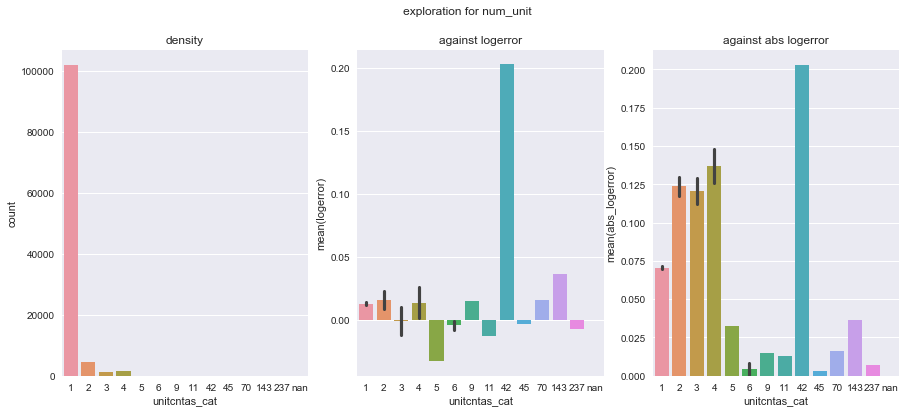

In [92]:
print_samples('unitcnt')
prop_missing, train_missing = missing_ratio('unitcnt')
visual_analysis_num_as_cat('unitcnt', 'num_unit')

In [93]:
# missing rate is OK, distribution is quite umbalanced. Need some engineering to make it workable
feature_info['unitcnt'] = ['num_unit', 'num', 2, prop_missing, train_missing]

### yardbuildingsqft17

Description: Patio in  yard.

data type: float64
sample data points: 904.0, 900.0, 676.0, 168.0, 356.0, 253.0, 440.0, 200.0
missing ratio prop: 0.9729
missing ratio train: 0.9700


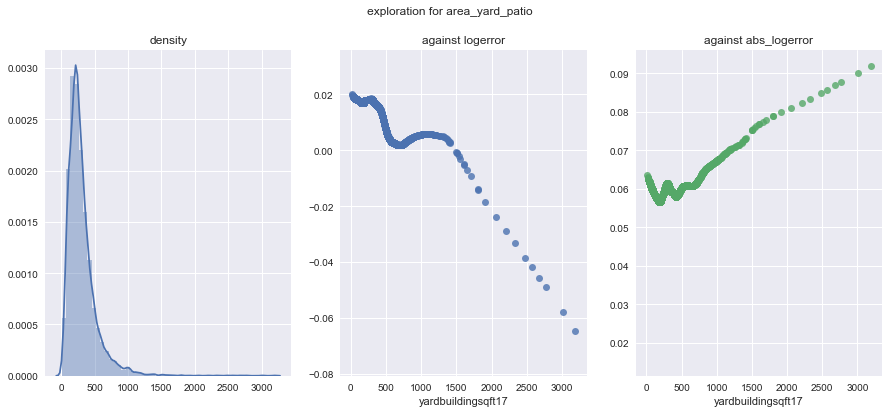

In [94]:
print_samples('yardbuildingsqft17')
prop_missing, train_missing = missing_ratio('yardbuildingsqft17')
visual_analysis_num('yardbuildingsqft17', 'area_yard_patio')

In [95]:
# missing rate too high
feature_info['yardbuildingsqft17'] = ['area_yard_patio', 'num', 4, prop_missing, train_missing]

### yardbuildingsqft26

Description: Storage shed/building in yard.

data type: float64
sample data points: 324.0, 100.0, 192.0, 288.0, 230.0, 180.0, 280.0, 25.0
missing ratio prop: 0.9991
missing ratio train: 0.9990


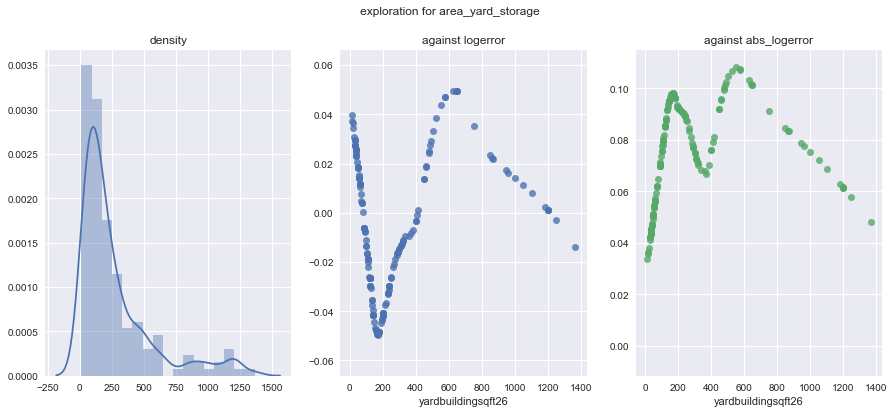

In [96]:
print_samples('yardbuildingsqft26')
prop_missing, train_missing = missing_ratio('yardbuildingsqft26')
visual_analysis_num('yardbuildingsqft26', 'area_yard_storage')

In [97]:
# missing rate too high
feature_info['yardbuildingsqft26'] = ['area_yard_storage', 'num', 4, prop_missing, train_missing]

### yearbuilt

Description:  The Year the principal residence was built. 

data type: float64
sample data points: 1976.0, 1987.0, 1960.0, 1954.0, 2000.0, 1975.0, 1978.0, 1954.0
missing ratio prop: 0.0180
missing ratio train: 0.0063


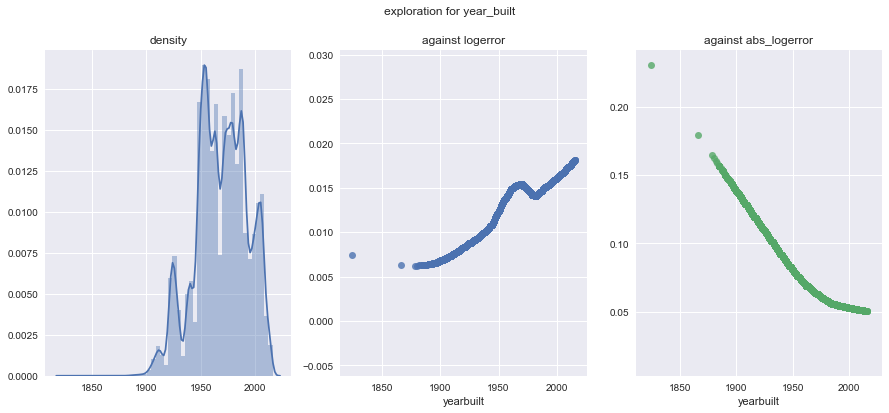

In [98]:
print_samples('yearbuilt')
prop_missing, train_missing = missing_ratio('yearbuilt')
visual_analysis_num('yearbuilt', 'year_built')

In [99]:
# high quality feature
feature_info['yearbuilt'] = ['year_built', 'num', 1, prop_missing, train_missing]

### numberofstories

Description: Number of stories or levels the home has. Apprently, it cannot be zero, so Na are true missing.

data type: float64
sample data points: 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0
missing ratio prop: 0.7709
missing ratio train: 0.7727


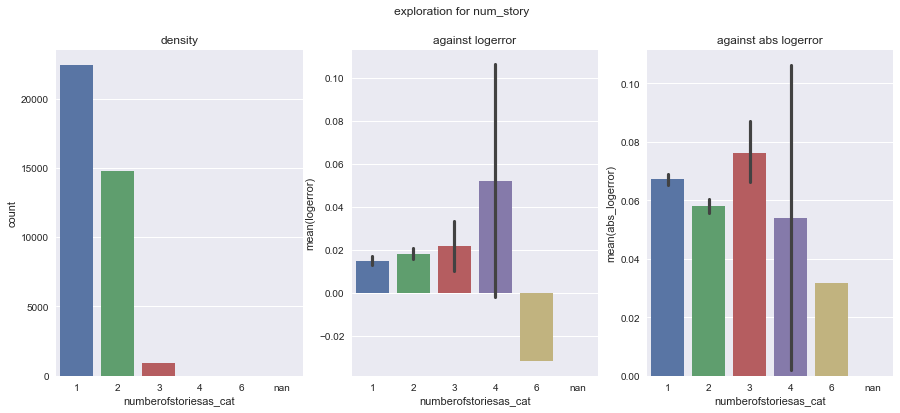

In [100]:
print_samples('numberofstories')
prop_missing, train_missing = missing_ratio('numberofstories')
visual_analysis_num_as_cat('numberofstories', 'num_story')

In [101]:
# missing rate is a bit high, but some pattern between group 1 and 2
feature_info['numberofstories'] = ['num_story', 'num', 2, prop_missing, train_missing]

### fireplaceflag

Description: Is a fireplace present in this home. 

data type: object
sample data points: True, True, True, True, True, True, True, True


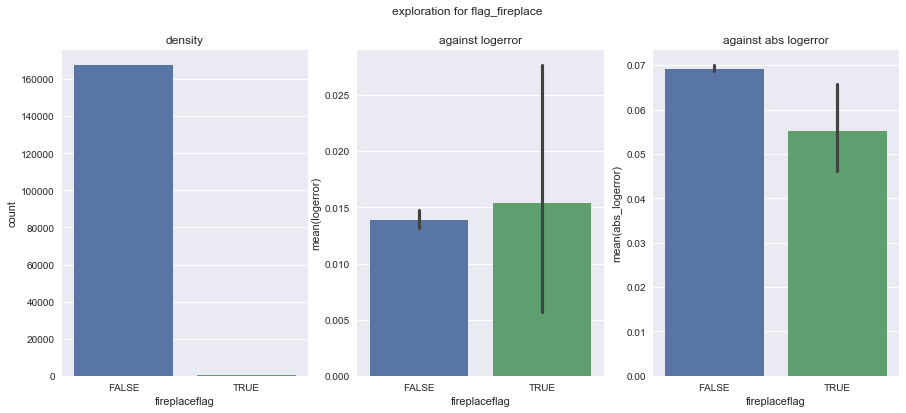

In [102]:
print_samples('fireplaceflag')
mark_flag_col('fireplaceflag')
visual_analysis_cat('fireplaceflag', 'flag_fireplace')

In [103]:
# too much unbalanced
feature_info['fireplaceflag'] = ['flag_fireplace', 'cat', 4, 0.0, 0.0]

### structuretaxvaluedollarcnt

Description: The assessed value of the built structure on the parcel.

data type: float64
sample data points: 142420.0, 209646.0, 133312.0, 96240.0, 373774.0, 7245.0, 113434.0, 178500.0
missing ratio prop: 0.0170
missing ratio train: 0.0032


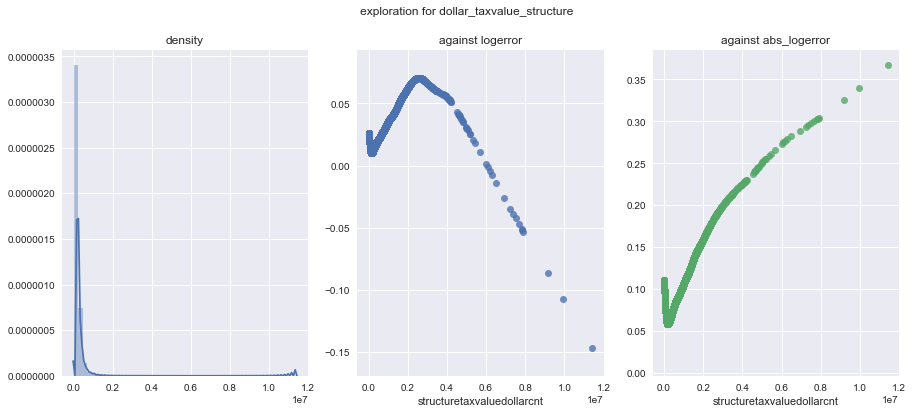

In [104]:
print_samples('structuretaxvaluedollarcnt')
prop_missing, train_missing = missing_ratio('structuretaxvaluedollarcnt')
visual_analysis_num('structuretaxvaluedollarcnt', 'dollar_taxvalue_structure')

In [105]:
# the distribution is quite concentraded, but there is pattern there.
feature_info['structuretaxvaluedollarcnt'] = ['dollar_taxvalue_structure', 'num', 1, prop_missing, train_missing]

### taxvaluedollarcnt

Description: The total tax assessed value of the parcel.

data type: float64
sample data points: 155093.0, 914000.0, 359217.0, 189270.0, 1414962.0, 397389.0, 439568.0, 571000.0
missing ratio prop: 0.0129
missing ratio train: 0.0002


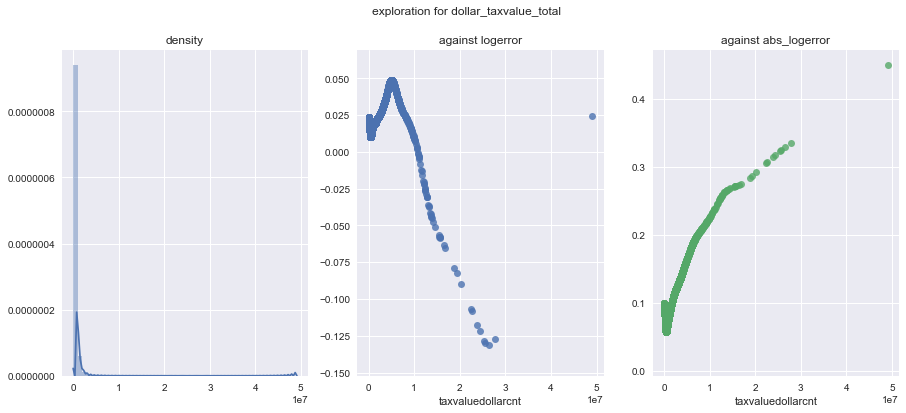

In [106]:
print_samples('taxvaluedollarcnt')
prop_missing, train_missing = missing_ratio('taxvaluedollarcnt')
visual_analysis_num('taxvaluedollarcnt', 'dollar_taxvalue_total')

In [107]:
# low missing rate, rich pattern in high density area.
feature_info['taxvaluedollarcnt'] = ['dollar_taxvalue_total', 'num', 1, prop_missing, train_missing]

### assessmentyear

Description: The year of the property tax assessment. It contains no information than data year.

In [108]:
print('unique assessment years for 2016 data: ' + str(train_2016['assessmentyear'].unique()))
print('unique assessment years for 2017 data: ' + str(train_2017['assessmentyear'].unique()))

unique assessment years for 2016 data: [ 2015.]
unique assessment years for 2017 data: [ 2016.    nan]


In [109]:
feature_info['assessmentyear'] = ['year_assess', 'num', 4, 0.0, 0.0]

### landtaxvaluedollarcnt

Description: The assessed value of the land area of the parcel.

data type: float64
sample data points: 579195.0, 25270.0, 79376.0, 1641800.0, 538295.0, 27721.0, 281341.0, 81344.0
missing ratio prop: 0.0214
missing ratio train: 0.0002


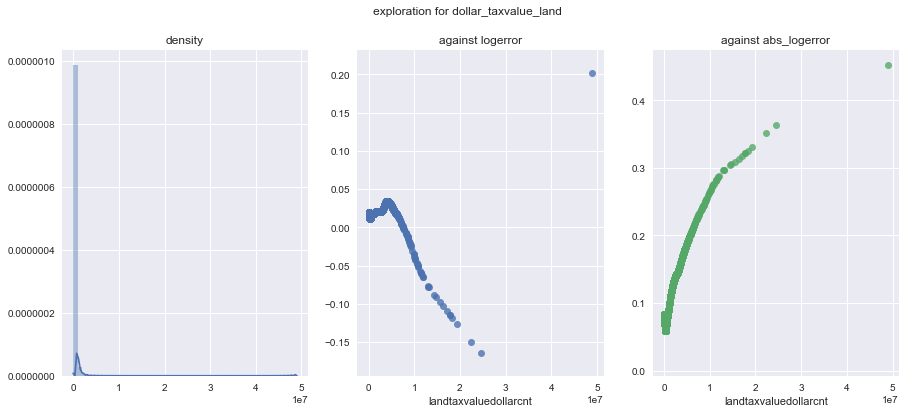

In [110]:
print_samples('landtaxvaluedollarcnt')
prop_missing, train_missing = missing_ratio('landtaxvaluedollarcnt')
visual_analysis_num('landtaxvaluedollarcnt', 'dollar_taxvalue_land')

In [111]:
# again rich pattern, and different from 2 above
feature_info['landtaxvaluedollarcnt'] = ['dollar_taxvalue_land', 'num', 1, prop_missing, train_missing]

### taxamount

Description: The total property tax assessed for that assessment year. 

data type: float64
sample data points: 6640.57, 4645.8, 2402.56, 5751.78, 5833.4, 1128.09, 936.46, 4067.21
missing ratio prop: 0.0090
missing ratio train: 0.0003


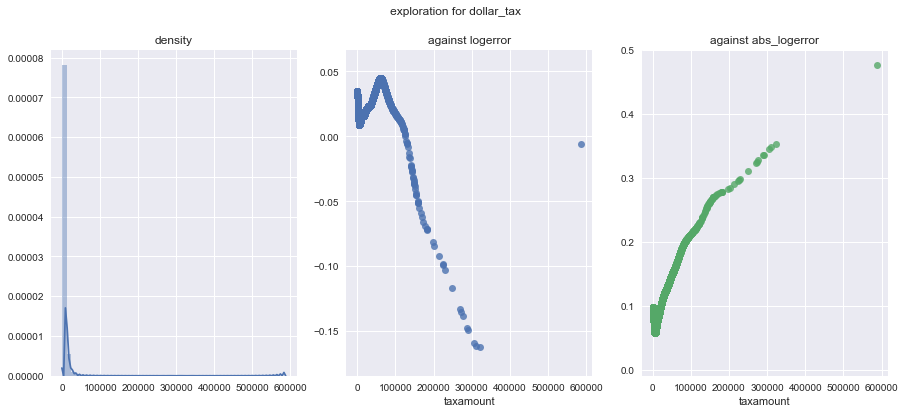

In [112]:
print_samples('taxamount')
prop_missing, train_missing = missing_ratio('taxamount')
visual_analysis_num('taxamount', 'dollar_tax')

In [113]:
# another pattern-rich feature
feature_info['taxamount'] = ['dollar_tax', 'num', 1, prop_missing, train_missing]

### taxdelinquencyflag

Description: Property taxes for this parcel are past due as of 2015. Note, it is a flag variable with 'Y' and na only.

data type: object
sample data points: Y, Y, Y, Y, Y, Y, Y, Y
number of TRUE: 4683


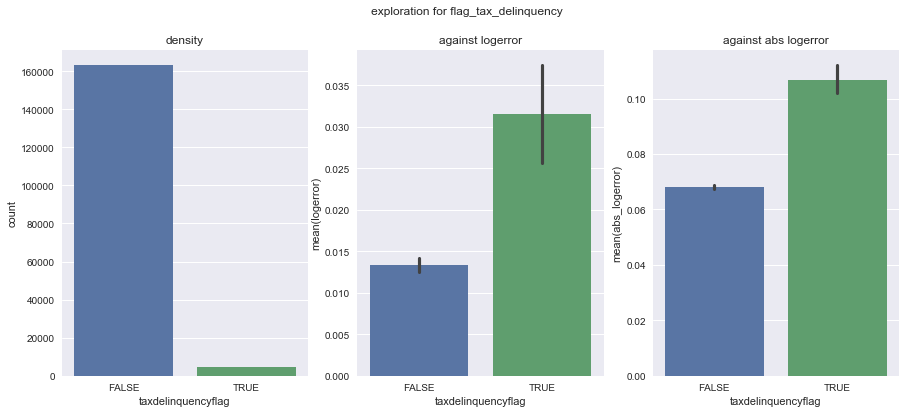

In [114]:
recover_col('taxdelinquencyflag')
print_samples('taxdelinquencyflag')
prop_data_marks_true = prop_data['taxdelinquencyflag'] == 'Y'
prop_data.loc[prop_data.index[prop_data_marks_true], 'taxdelinquencyflag'] = 'TRUE'
prop_data.loc[prop_data.index[~prop_data_marks_true], 'taxdelinquencyflag'] = 'FALSE'
train_data_marks_true = train_data['taxdelinquencyflag'] == 'Y'
train_data.loc[train_data.index[train_data_marks_true], 'taxdelinquencyflag'] = 'TRUE'
train_data.loc[train_data.index[~train_data_marks_true], 'taxdelinquencyflag'] = 'FALSE'

visual_analysis_cat('taxdelinquencyflag', 'flag_tax_delinquency')
print('number of TRUE: %d' % (np.sum(train_data['taxdelinquencyflag'] == 'TRUE')))

In [115]:
# too unbalanced distribution.
feature_info['taxdelinquencyflag'] = ['flag_tax_delinquency', 'cat', 4, 0.0, 0.0]

### taxdelinquencyyear

Description: Year for which the unpaid propert taxes were due.

data type: float64
sample data points: 11.0, 15.0, 15.0, 14.0, 15.0, 15.0, 13.0, 15.0
missing ratio prop: 0.9811
missing ratio train: 0.9721


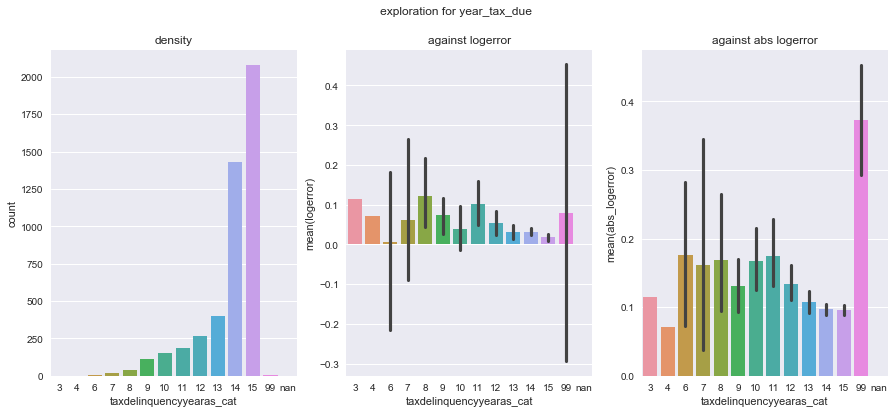

In [116]:
print_samples('taxdelinquencyyear')
prop_missing, train_missing = missing_ratio('taxdelinquencyyear')
visual_analysis_num_as_cat('taxdelinquencyyear', 'year_tax_due')

In [117]:
# too high missing rate
feature_info['taxdelinquencyyear'] = ['year_tax_due', 'num', 4, prop_missing, train_missing]

### censustractandblock

Description: Census tract and block ID combined - also contains blockgroup assignment by extension. Unlike rawcensusandblock, everything is put ahead of decimal point, and it confirms that information of rawcensusblock is only valid up to 6 digits. 14 digit string, again first 4 digits are fips. decompose into census_tract and block as 6 vs. 4 digits string

In [118]:
recover_col('censustractandblock')
print_samples('censustractandblock', n_digit=6)
prop_missing, train_missing = missing_ratio('censustractandblock')

def census_info_split_inner(data):
    data['census'] = data['censustractandblock'].apply(lambda x: x[4:10] if not x == 'nan' else np.nan)
    data['block'] = data['censustractandblock'].apply(lambda x: x[10:] if not x == 'nan' else np.nan)

if not prop_data['censustractandblock'].dtype == 'O':
    prop_data['censustractandblock'] = prop_data['censustractandblock'].apply(lambda x: str(int(x)) if not np.isnan(x) else 'nan')
if not train_data['censustractandblock'].dtype == 'O':
    train_data['censustractandblock'] = train_data['censustractandblock'].apply(lambda x: str(int(x)) if not np.isnan(x) else 'nan')

census_info_split_inner(prop_data)
census_info_split_inner(train_data)
print('n categories census: %d' % len(train_data['census'].unique()))
print('n categories block: %d' % len(train_data['block'].unique()))

data type: float64
sample data points: 60590626434015.000000, 61110060002003.000000, 60372044202000.000000, 60375520013008.000000, 60374013112005.000000, 60379010091027.000000, 60375309021000.000000, 60375700013001.000000
missing ratio prop: 0.0251
missing ratio train: 0.0053
n categories census: 3018
n categories block: 797


In [119]:
feature_info['censustractandblock'] = ['census_block', 'none', 4, prop_missing, train_missing]
feature_info['census'] = ['census', 'cat', 3, prop_missing, train_missing]
feature_info['block'] = ['block', 'cat', 3, prop_missing, train_missing]

In [120]:
save_feature_info_to_csv()

## Relationship between variables

We explore some inter-related variables.

### num_bathroom

It has two version, the zillow version and assessor version: calculatedbathnbr being zillow version, bathroomcnt being assessor version. From analysis below, it shows that what zillow marked as NaN while assessor has value are mostly 0 bathrooms percels. And zillow version keeps no rows of 0 bathrooms, which seems a pretty reasonable assumption. And besides disagreement in NaNs there is no disagreement on values. So between the two I would only keep the zillow one.  

In [121]:
diff_col = prop_data['bathroomcnt'] - prop_data['calculatedbathnbr']  # first only check places where they both have value
print('max_diff: %.2f' % np.nanmax(diff_col.values))
print('min_diff: %.2f' % np.nanmin(diff_col.values))
print('n_zillow_extra values: %d' % (np.sum(np.logical_and(~prop_data['calculatedbathnbr'].isnull(), prop_data['bathroomcnt'].isnull()))))
print('n_assessor_extra values: %d' % (np.sum(np.logical_and(prop_data['calculatedbathnbr'].isnull(), ~prop_data['bathroomcnt'].isnull()))))

n_assessor_extra_rows = prop_data.index[np.logical_and(prop_data['calculatedbathnbr'].isnull(), ~prop_data['bathroomcnt'].isnull())]
n_assessor_extra_vals = prop_data.loc[n_assessor_extra_rows, 'bathroomcnt']
print(collections.Counter(n_assessor_extra_vals))

print('n_zero_bathroom observations in zillow: %d' % np.sum(prop_data['calculatedbathnbr'] == 0))

max_diff: 0.00
min_diff: 0.00
n_zillow_extra values: 0
n_assessor_extra values: 246068
Counter({0.0: 230084, 2.0: 14443, 1.5: 629, 2.5: 524, 3.5: 148, 4.5: 111, 0.5: 33, 5.5: 32, 6.5: 25, 1.0: 16, 1.75: 9, 8.5: 7, 7.5: 6, 3.0: 1})
n_zero_bathroom observations in zillow: 0


### area_firstfloor

This one also has a zillow version and an assessor version, finishedfloor1squarefeet being zillow version, finishedsquarefeet50 being assessor version. For this variable, we find that:
- zillow and assessor has no disagreement on NaNs.
- for all those disagreement on values, zillow shrinks some extreme values.
I would keep the zillow version for it.

max_diff: 0.00
min_diff: -30961.00
n_diff: 2040
n_zillow_extra values: 0
n_assessor_extra values: 0
zillow max value: 31303.0000


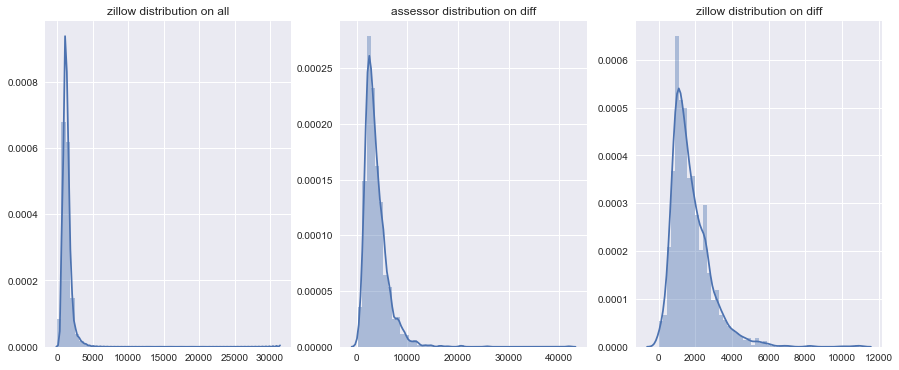

In [122]:
diff_col = (prop_data['finishedfloor1squarefeet'] - prop_data['finishedsquarefeet50']).values
print('max_diff: %.2f' % np.nanmax(diff_col))
print('min_diff: %.2f' % np.nanmin(diff_col))
diff_idx = np.abs(diff_col) > 1e-12
print('n_diff: %d' % np.sum(diff_idx))
print('n_zillow_extra values: %d' % (np.sum(np.logical_and(~prop_data['finishedfloor1squarefeet'].isnull(), \
                                                           prop_data['finishedsquarefeet50'].isnull()))))
print('n_assessor_extra values: %d' % (np.sum(np.logical_and(prop_data['finishedsquarefeet50'].isnull(), \
                                                             ~prop_data['finishedfloor1squarefeet'].isnull()))))

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
zillow_values = prop_data['finishedfloor1squarefeet'].values
sns.distplot(zillow_values[~np.isnan(zillow_values)], ax=ax1).set_title('zillow distribution on all')
sns.distplot(prop_data['finishedsquarefeet50'].values[diff_idx], ax=ax2).set_title('assessor distribution on diff')
sns.distplot(prop_data['finishedfloor1squarefeet'].values[diff_idx], ax=ax3).set_title('zillow distribution on diff')
fig.show()
print('zillow max value: %.4f' % np.nanmax(zillow_values))

### area_living

From data exploration, we find that calculatedfinishedsquarefeet and finishedsquarefeet12 shows very similar pattern against logerror. Again, they have no diff in values, just disagreement on NaNs. Looks they both have quite large values, and the extra value distribution is not significantly different from total population. Let's keep the one with less NaN.

max_diff: 0.00
min_diff: 0.00
n_calc extra values: 439802
n_type12 extra values: 0


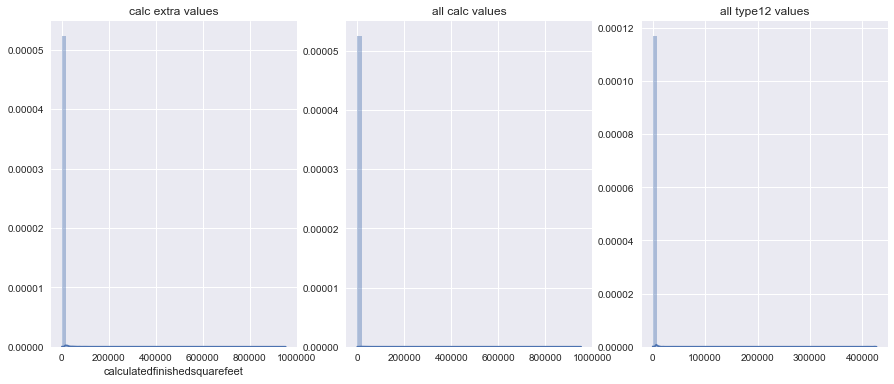

In [123]:
diff_col = train_data['calculatedfinishedsquarefeet'] - train_data['finishedsquarefeet12']
print('max_diff: %.2f' % np.nanmax(diff_col.values))
print('min_diff: %.2f' % np.nanmin(diff_col.values))

print('n_calc extra values: %d' % (np.sum(np.logical_and(~prop_data['calculatedfinishedsquarefeet'].isnull(), \
                                                           prop_data['finishedsquarefeet12'].isnull()))))
print('n_type12 extra values: %d' % (np.sum(np.logical_and(prop_data['calculatedfinishedsquarefeet'].isnull(), \
                                                             ~prop_data['finishedsquarefeet12'].isnull()))))

val_idx = prop_data.index[np.logical_and(~prop_data['calculatedfinishedsquarefeet'].isnull(), \
                                                           prop_data['finishedsquarefeet12'].isnull())]

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.distplot(prop_data.loc[val_idx, 'calculatedfinishedsquarefeet'], ax=ax1).set_title('calc extra values')
calc_values = prop_data['calculatedfinishedsquarefeet'].values
sns.distplot(calc_values[~np.isnan(calc_values)], ax=ax2).set_title('all calc values')
type12_values = prop_data['finishedsquarefeet12'].values
sns.distplot(type12_values[~np.isnan(type12_values)], ax=ax3).set_title('all type12 values')
fig.show()

### tax values

We have 3 types of tax values, _structure, _land and _total. Just to verity that total == structure + land, and keep that in mind in feature engineering.

In [124]:
sum_tax = prop_data['landtaxvaluedollarcnt'] + prop_data['structuretaxvaluedollarcnt']
total = prop_data['taxvaluedollarcnt']
idx_use = prop_data.index[np.logical_and(~sum_tax.isnull(), ~total.isnull())]
diff_vals = (sum_tax - total).values
print('max_diff: %.2f' % np.nanmax(diff_vals))
print('min_diff: %.2f' % np.nanmin(diff_vals))

max_diff: 0.00
min_diff: 0.00
